In [1]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser
import scipy.io
import os
from collections import OrderedDict

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, ConcatDataset, Dataset, Subset

from torchvision.transforms import Compose, ToTensor, Lambda, Resize, Pad
from torchvision.datasets.mnist import MNIST, FashionMNIST
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Using device: {device}\t"
    + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU")
)

Using device: cuda	NVIDIA GeForce RTX 3060


## Signal 1-D Transformer

In [2]:
feature_dim=400

In [3]:
class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)
    
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width      # the number of tokens
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)

In [4]:
# width = 72*5
# width = 60
# width = 384
width = 192
class signalTransformer(nn.Module):
    def __init__(self,num = 5):
        super().__init__()
        self.num = num
        self.A_conv=nn.Sequential(
            nn.Conv1d(feature_dim,20,3,1,1),
            nn.Conv1d(20,1,3,1,1),
        )
        self.transformer = Transformer(
            # width=72*self.num,          # Three test: rwidth = 72*5/30*5/384
            width = width,      # the number of tokens
            layers=2,
            heads=8,
            # heads=10,        # only for width = 60
            # attn_mask=build_attention_mask(32)
        )
        self.ln_final = LayerNorm(width)
        self.final_conv = nn.Conv1d(int(11520/width)*2,1,3,1,1)
        self.fc = nn.Linear(width,400)
    def forward(self,x):
        x = x.reshape(x.shape[0],feature_dim+1,11520)    # 1,32,360  B,w,h
        #x = x.permute(0,1,3,5,2,4)
        A = x[:,:feature_dim,:]
        y = x[:,-1,:]
        A = self.A_conv(A).reshape(x.shape[0],2, 16, 5, 12, 6)
        A = A.reshape(x.shape[0],int(11520/width),width)    # 1,32,360  B,w,h
        # x = x.permute(1,0,2)        # 32,1,360  # w,B,h
        A = self.transformer(A)
        y = y.reshape(x.shape[0],2, 16, 5, 12, 6)
        y = y.reshape(x.shape[0],int(11520/width),width)    # 1,32,360  B,w,h
        # x = x.permute(1,0,2)        # 32,1,360  # w,B,h
        y = self.transformer(y)
        # x = x.permute(1,0,2)
        x = torch.concat([A,y],dim=1)
        x = self.ln_final(x)
        x = self.final_conv(x)
        return self.fc(x.squeeze(1))
    
class signalTransformerEmbedT(nn.Module):
    def __init__(self,num = 5, time_emb_dim = 100):
        super().__init__()
        self.num = num
        self.transformer = Transformer(
            # width=72*self.num,          # Three test: rwidth = 72*5/30*5/384
            width = width,
            layers=2,
            heads=8,
            # heads=10,        # only for width = 60
            # attn_mask=build_attention_mask(32)
        )
        self.ln_final = LayerNorm(width)
        self.final_conv = nn.Conv1d(int(11520/width)+1,1,3,1,1)

        self.make_te = nn.Linear(time_emb_dim, width)
        self.fc = nn.Linear(width,400)

    def forward(self,x,t):
       
        x = x.reshape(x.shape[0],2, 16, 5, 12, 6)    # 1,32,360  B,w,h
        x = x.reshape(x.shape[0],int(11520/width),width)    # 1,32,360  B,w,h
        te = self.make_te(t)       # te: 1,width
        x = torch.concat([x,te], dim=1) # x: 1, int(11520/width)+1, 
        # x = x.permute(1,0,2)        # 32,1,360  # w,B,h
        
        x = self.transformer(x)
        # x = x.permute(1,0,2)
        x = self.ln_final(x)
        x = self.final_conv(x)
        return self.fc(x.squeeze(1))
    

class signalTransformerEmbedTPro(nn.Module):
    def __init__(self,num = 5, time_emb_dim = 100, time_emb_factor = 10):
        super().__init__()
        if time_emb_dim % time_emb_factor != 0:
            assert("Factor should be able to divdie time_emb_dim!")
        self.num = num
        self.time_emb_dim = time_emb_dim
        self.time_emb_factor = time_emb_factor
        self.time_emb_din = time_emb_dim//time_emb_factor
        self.transformer = Transformer(
            # width=72*self.num,          # Three test: rwidth = 72*5/30*5/384
            width = width,
            layers=2,
            heads=8,
            # heads=10,        # only for width = 60
            # attn_mask=build_attention_mask(32)
        )
        self.ln_final = LayerNorm(width)
        self.final_conv = nn.Conv1d(int(11520/width)+time_emb_factor,1,3,1,1)

        self.make_te = nn.ModuleList([nn.Linear(self.time_emb_din, width) for _ in range(time_emb_factor)])

        self.fc = nn.Linear(width,400)

    def forward(self,x,t):
       
        x = x.reshape(x.shape[0],2, 16, 5, 12, 6)    # 1,32,360  B,w,h
        x = x.reshape(x.shape[0],int(11520/width),width)    # 1,32,360  B,w,h
        # te = self.make_te(t)       # te: 1,width
        te = torch.zeros(x.shape[0], self.time_emb_factor, width).to(x.device)   # t: B,1,100
        for i, l in enumerate(self.make_te):
            te[:,i,:] = l(t[:,0,self.time_emb_din*i:self.time_emb_din*(i+1)])   # te: B,10,192
        x = torch.concat([x,te], dim=1) # x: 1, int(11520/width)+1, 
        # x = x.permute(1,0,2)        # 32,1,360  # w,B,h
        
        x = self.transformer(x)
        # x = x.permute(1,0,2)
        x = self.ln_final(x)
        x = self.final_conv(x)
        return self.fc(x.squeeze(1))
    
class signalTransformer_A(nn.Module):
    def __init__(self,num = 5):
        super().__init__()
        self.num = num
        self.A_conv=nn.Sequential(
            nn.Conv1d(feature_dim,20,3,1,1),
            nn.Conv1d(20,1,3,1,1),
        )
        self.transformer = Transformer(
            # width=72*self.num,          # Three test: rwidth = 72*5/30*5/384
            width = width,      # the number of tokens
            layers=2,
            heads=8,
            # heads=10,        # only for width = 60
            # attn_mask=build_attention_mask(32)
        )
        self.ln_final = LayerNorm(width)
        self.final_conv = nn.Conv1d(int(11520/width),1,3,1,1)
        self.fc = nn.Linear(width,400)
    def forward(self,x):
        #input A(N,400,11520)
        x = x.reshape(x.shape[0],feature_dim, 11520)
        #x = x.reshape(x.shape[0],2, 16, 5, 12, 6)    # 1,32,360  B,w,h
        #x = x.permute(0,1,3,5,2,4)
        x = self.A_conv(x).reshape(x.shape[0],2, 16, 5, 12, 6)
        x = x.reshape(x.shape[0],int(11520/width),width)    # 1,32,360  B,w,h
        # x = x.permute(1,0,2)        # 32,1,360  # w,B,h
        x = self.transformer(x)
        # x = x.permute(1,0,2)
        x = self.ln_final(x)
        x = self.final_conv(x)
        
        return self.fc(x.squeeze(1))

In [5]:
sig_tran = signalTransformer()
y0 = torch.rand((45,401,11520))
#t = torch.rand((45,1,100))
print(sig_tran(y0).shape)
sig_tran_A = signalTransformer_A()
y_A = torch.rand((45,400,11520))
print(sig_tran_A(y_A).shape)

torch.Size([45, 400])
torch.Size([45, 400])


## UNet with transformer

In [6]:
class MyDDPM(nn.Module):
    def __init__(
        self,
        network,
        n_steps=200,
        min_beta=10**-4,
        max_beta=0.02,
        device=None,
        image_chw=(1, 20, 200),
    ):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device
        )  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor(
            [torch.prod(self.alphas[: i + 1]) for i in range(len(self.alphas))]
        ).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = (
            a_bar.sqrt().reshape(n, 1, 1, 1) * x0
            + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        )
        return noisy

    def backward(self, x, y, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, y, t)
    


def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:, ::2] = torch.sin(t * wk[:, ::2])
    embedding[:, 1::2] = torch.cos(t * wk[:, ::2])

    return embedding

class MyBlock(nn.Module):
    def __init__(
        self,
        shape,
        in_c,
        out_c,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [7]:
class MySigUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MySigUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.signal_transformer = signalTransformer(num=5)
        self.signal_transformer_A = signalTransformer_A(num=5)
        self.signal_transformer_embed_t = signalTransformerEmbedT(num=5, time_emb_dim=time_emb_dim)
        self.te0 = self._make_te(time_emb_dim, 1)
        self.mix_conv=nn.Conv2d(2, 1, 3, 1, 1)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((2, 20, 20), 2, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10),
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 10, 10), 10, 20),
            MyBlock((20, 10, 10), 20, 20),
            MyBlock((20, 10, 10), 20, 20),
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 5, 5), 20, 40),
            MyBlock((40, 5, 5), 40, 40),
            MyBlock((40, 5, 5), 40, 40),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 2, 2), 40, 20),
            MyBlock((20, 2, 2), 20, 20),
            MyBlock((20, 2, 2), 20, 40),
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 5, 5), 80, 40),
            MyBlock((40, 5, 5), 40, 20),
            MyBlock((20, 5, 5), 20, 20),
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 10, 10), 40, 20),
            MyBlock((20, 10, 10), 20, 10),
            MyBlock((10, 10, 10), 10, 10),
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 20, 20), 20, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10, normalize=False),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)       

    def forward(self, x, y, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        
        
        t = self.time_embed(t)
        n = len(x)
        
        #A = y[:,:feature_dim,:]
        #y = y[:,-1,:]

        # out_y = self.signal_transformer(y + self.te0(t).reshape(n, -1, 1)).reshape(n,1,20,20)       # add time embedding to y

        # out_y = out_y + self.te0(t).reshape(n, -1, 1, 1)           # add time embedding to out_y

        # out_y = self.signal_transformer_embed_t(y, t).reshape(n,1,20,20)    # concat time embeding to y

        #out_A = self.signal_transformer_A(A).reshape(n,1,20,20)
        out_y = self.signal_transformer(y).reshape(n,1,20,20)       # no time embedding to y
        #out_y = torch.concat([out_A,out_y],dim=1)
        #out_y = self.mix_conv(out_y)
        
        out1 = self.b1(torch.cat((out_y, x + self.te1(t).reshape(n, -1, 1, 1)), dim=1))  # (N, 10, 28, 28)
        
        out2 = self.b2(
            self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1)
        )  # (N, 20, 14, 14)
        out3 = self.b3(
            self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 7, 7)

        out_mid = self.b_mid(
            self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)


        out = self.conv_out(out)[:,0,:,:]
        out = out[:, None, :, :]

        return out, out_y

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out)
        )
    


class MySigUNetEmbedY(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MySigUNetEmbedY, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.signal_transformer = signalTransformer(num=5)
        self.signal_transformer_embed_t = signalTransformerEmbedT(num=5, time_emb_dim=time_emb_dim)
        self.te0 = self._make_te(time_emb_dim, 1)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((2, 20, 20), 2, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10),
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 10, 10), 10, 20),
            MyBlock((20, 10, 10), 20, 20),
            MyBlock((20, 10, 10), 20, 20),
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 5, 5), 20, 40),
            MyBlock((40, 5, 5), 40, 40),
            MyBlock((40, 5, 5), 40, 40),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 2, 2), 40, 20),
            MyBlock((20, 2, 2), 20, 20),
            MyBlock((20, 2, 2), 20, 40),
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 5, 5), 80, 40),
            MyBlock((40, 5, 5), 40, 20),
            MyBlock((20, 5, 5), 20, 20),
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 10, 10), 40, 20),
            MyBlock((20, 10, 10), 20, 10),
            MyBlock((10, 10, 10), 10, 10),
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 20, 20), 20, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10, normalize=False),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)       

    def forward(self, x, y, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        
        
        t = self.time_embed(t)
        n = len(x)

        # out_y = self.signal_transformer(y + self.te0(t).reshape(n, -1, 1)).reshape(n,1,20,20)       # add time embedding to y

        # out_y = out_y + self.te0(t).reshape(n, -1, 1, 1)           # add time embedding to out_y

        out_y = self.signal_transformer_embed_t(y, t).reshape(n,1,20,20)    # concat time embeding to y

        # out_y = self.signal_transformer(y).reshape(n,1,20,20)       # no time embedding to y
        


        out1 = self.b1(torch.cat((out_y, x + self.te1(t).reshape(n, -1, 1, 1)), dim=1))  # (N, 10, 28, 28)
        
        out2 = self.b2(
            self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1)
        )  # (N, 20, 14, 14)
        out3 = self.b3(
            self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 7, 7)

        out_mid = self.b_mid(
            self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)


        out = self.conv_out(out)[:,0,:,:]
        out = out[:, None, :, :]

        return out, out_y

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out)
        )
    
class MySigUNetEmbedYPro(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MySigUNetEmbedYPro, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        self.signal_transformer = signalTransformerEmbedTPro(num=5, time_emb_dim=time_emb_dim, time_emb_factor=10)
        self.te0 = self._make_te(time_emb_dim, 1)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((2, 20, 20), 2, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10),
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 10, 10), 10, 20),
            MyBlock((20, 10, 10), 20, 20),
            MyBlock((20, 10, 10), 20, 20),
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 5, 5), 20, 40),
            MyBlock((40, 5, 5), 40, 40),
            MyBlock((40, 5, 5), 40, 40),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 2, 2), 40, 20),
            MyBlock((20, 2, 2), 20, 20),
            MyBlock((20, 2, 2), 20, 40),
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 5, 5), 80, 40),
            MyBlock((40, 5, 5), 40, 20),
            MyBlock((20, 5, 5), 20, 20),
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 10, 10), 40, 20),
            MyBlock((20, 10, 10), 20, 10),
            MyBlock((10, 10, 10), 10, 10),
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 20, 20), 20, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10, normalize=False),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)       

    def forward(self, x, y, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        
        
        t = self.time_embed(t)
        n = len(x)

        out_y = self.signal_transformer(y, t).reshape(n,1,20,20) 

        out1 = self.b1(torch.cat((out_y, x + self.te1(t).reshape(n, -1, 1, 1)), dim=1))  # (N, 10, 28, 28)
        
        out2 = self.b2(
            self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1)
        )  # (N, 20, 14, 14)
        out3 = self.b3(
            self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 7, 7)

        out_mid = self.b_mid(
            self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)


        out = self.conv_out(out)[:,0,:,:]
        out = out[:, None, :, :]

        return out, out_y

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out)
        )

## Load Dataset

In [90]:
class MyDataset(Dataset):
    def __init__(self, A_path, Y_path, gt_path):
        # load A
        
        A0 = torch.zeros(16*5*72,20,20,dtype=torch.complex128)
        for j in range(20):
            for i in range(20):
                path = "adc_data_"+str(20*j+i+1)+".mat"
                mat = scipy.io.loadmat(os.path.join(A_path,path))
                A_now = torch.from_numpy(mat["adcData1Complex"])
                A_now = torch.mean(A_now,dim=-1)
                #print(A_now.shape)
                #A_now = A_now[:,4:9,:]
                #A_now = A_now[:,1:6,:]  #140cm
                #A_now = A_now[:,2:7,:]  #115cm
                #A_now = A_now[:,1:6,:]  #95cm
                #A_now = A_now[:,2:7,:]  #70cm
                #A_now = A_now[:,2:7,:]  #55cm
                A_now = A_now[:,9:14,:]  #55cm
                A_new = A_now.reshape(-1,1)
                A0[:,j,i] = A_new.reshape(-1)
        
        '''
        #A_path = './datasets/A/A_0.mat'
        mat=scipy.io.loadmat(A_path)
        A0=torch.from_numpy(mat["recoverd_A"])
        A0=np.reshape(A0,(16*5*72,20,20),order='F')
        A0=np.reshape(A0,(16,5,72,20,20),order='F')
        A0=A0.reshape(-1,20,20)
        A0=np.reshape(A0,(-1,20*20),order='F')
        '''
        #A0 = np.load(os.path.join(A_path,'simulate_A.npy'))
        #A0 = np.load(A_path)
        #A0 = torch.from_numpy(A0)
        
        A0 = A0.reshape(-1, 20**2)
        self.A = torch.concat([A0.real,A0.imag],dim=0)
        #use amp only
        #self.A = torch.concat([torch.abs(A0),torch.abs(A0)],dim=0)
        
        
        if Y_path!=None:
            self.Y = []
            self.gt = []
            #char = ['0','1','2','3','A','B','C','cup']
            #char = ['0','1','2','A','B']
            char = ['1','2','3','4','5','6','7','8']
            #char = ['9','10','11','12','13','14','15','16']
            #char = ['1','2','3']
            #char= ['shove','stand','board']
            #char = ['A','B','C']
            #char = ['knife','shove']
            #char = ['gun1','gun2']
            #char = ['discpos1','discpos2','discpos3','discpos4','discpos5']
            for i in range(len(char)*3):

                test = scipy.io.loadmat(os.path.join(Y_path,"adc_data_test"+char[i//3]+"_"+str(i%3+1)+".mat"))
                #test = scipy.io.loadmat(os.path.join(Y_path,"adc_data_test"+str(i%6+1)+".mat"))
                test=torch.from_numpy(test["adcData1Complex"]).to(torch.complex64)
                test = torch.mean(test,dim=-1)
                #test = test[:,4:9,:] # 5x5
                #test = test[:,1:6,:] # 5x5
                #test = test[:,2:7,:] # 5x5
                test = test[:,9:14,:] # 5x5

                #test =  np.load(os.path.join(Y_path,'signal_'+str(i)+'.npy'))
                #test = torch.from_numpy(test)

                test = test.reshape(-1).unsqueeze(-1)
                s_test = torch.concat([test.real,test.imag],dim=0).to(self.A.dtype)
                #concat A and Y
                s_test = torch.concat([self.A,s_test],dim=1)
                s_test=s_test.permute(1,0)
                #print(s_test.shape)

                #use amp only
                #s_test = torch.concat([torch.abs(test),torch.abs(test)],dim=0).to(self.A.dtype)
                self.Y.append(s_test)

                #gt = np.load(os.path.join(gt_path, 'gt_'+char[i//3]+'.npy'))
                gt = np.load(os.path.join('./datasets/gt_20x20/sep_gt', 'gt_'+str(int(char[i//3])+24)+'.npy'))

                #gt = gt[4:16,4:16]

                gt = torch.tensor(gt, dtype=self.A.dtype)
                gt = gt.reshape(-1)
                self.gt.append(gt)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.Y[idx], self.gt[idx]

    def get_A(self):
        return self.A


class GTDataset(Dataset):
    def __init__(self, gt_path):
        self.gt = []
        self.label = []
        #char = ['0','1','2','3','A','B','C','cup']#,'disc1','disc2','disc3','disc4','disc5','disc6']
        #char = ['disc1','disc2','disc3','disc4','disc5','disc6','discpos1','discpos2','discpos3','discpos4','discpos5']
        #char = ['discpos1','discpos2','discpos3','discpos4','discpos5']
        #char = ['knife2','shove2']
        #char = ['gun1','gun2']
        #char = ['0','1','2','A','B','shove','scissors','knife','stand','board',
        #        'hand2','hand2_90','hand2_180','hand2_270','hand5','hand5_90','hand5_180','hand5_270',
        #       'handgt0','handgt1','handgt2','handgt3','handgt4']
        char = ['0','1','2','A','B']
        #char = ['hand2','hand2_90','hand2_180','hand2_270','hand5','hand5_90','hand5_180','hand5_270','handgt0','handgt1','handgt2','handgt3','handgt4']
        
        #for n in range(30):
            #for i in range(len(char)*3):
        for i in range(36):
            #gt = np.load(os.path.join(gt_path, 'gt_'+char[i//3]+'.npy'))
            gt = np.load(os.path.join(gt_path, 'gt_'+str(i+1)+'.npy'))
            gt = torch.tensor(gt, dtype=torch.float32)

            #gt = gt[4:16,4:16]

            gt = gt.reshape((1, 20, 20))
            # gt = (gt-0.5)*2       # Norm to 0~1 or -1~1
            for _ in range(100):
                x_shift = random.randint(-4, 4)
                y_shift = random.randint(-4, 4)
                #self.label.append(i//3)
                self.label.append(i)
                self.gt.append(torch.roll(gt, shifts=(x_shift, y_shift), dims=(1, 2)))
        '''        
        for i in range(50):
            gt = np.load(os.path.join('./datasets/data_simulate/data_1029_gt_flat/', 'gt_'+str(i)+'.npy'))
            gt = torch.tensor(gt, dtype=torch.float32)
            
            #gt = gt[4:16,4:16]
            
            gt = gt.reshape((1, 20, 20))
            # gt = (gt-0.5)*2       # Norm to 0~1 or -1~1
            for _ in range(100):
                x_shift = random.randint(-4, 4)
                y_shift = random.randint(-4, 4)
                self.label.append(i)
                self.gt.append(torch.roll(gt, shifts=(x_shift, y_shift), dims=(1, 2)))
        '''
    def __len__(self):
        return len(self.gt)

    def __getitem__(self, idx):
        return self.gt[idx], self.label[idx]
    
class ToolDataset(Dataset):
    def __init__(self, gt_path):
        self.gt = []
        self.label = []
        #char = ['0','1','2','3','4','A','B','C','cup']
        char = ['0','1','2','A','B']
        for i in range(27):
            gt = np.load(os.path.join(gt_path, 'gt_'+char[i//3]+'.npy'))
            gt = torch.tensor(gt, dtype=torch.float32)
            
            #gt = gt[4:16,4:16]
            
            gt = gt.reshape((1, 20, 20))
            # gt = (gt-0.5)*2       # Norm to 0~1 or -1~1
            for _ in range(90):
                x_shift = random.randint(-4, 4)
                y_shift = random.randint(-8, 0)
                self.label.append(i//3)
                self.gt.append(torch.roll(gt, shifts=(x_shift, y_shift), dims=(1, 2)))

    def __len__(self):
        return len(self.gt)

    def __getitem__(self, idx):
        return self.gt[idx], self.label[idx]


# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([ToTensor(), 
                     Lambda(lambda x: (x - 0.5) * 2),
                     Resize(24),
                     Pad(5, fill=-1, padding_mode='constant'),
                     Resize(20),
                     ])



#A_path = './datasets/opt_cw_opt_mts/opt_cw_opt_mts/calibration'
A_path = './datasets/data_res50/calibration'
Y_path = './datasets/data_res50/test'
#A_path = './datasets/data1111/calibration/A.npy'
#Y_path = './datasets/data1111/baseline2'
#A_path = './datasets/data_rank'
#Y_path = './datasets/data_rank'
#A_path = './datasets/A/recovered_A_M200_reg_0.mat'
#Y_path = './datasets/opt_cw_opt_mts/opt_cw_opt_mts/test'
gt_path = './datasets/gt_20x20/seperation'
#gt_path = './datasets/data_rank/'
dataset_sample = MyDataset(A_path, Y_path, gt_path)
ds_fn = FashionMNIST
dataset_fmnist = ds_fn("./data", download=True, train=True, transform=transform)
dataset_number = GTDataset(gt_path)

In [9]:
A_path = './datasets/A/A_0.mat'
mat=scipy.io.loadmat(A_path)
A0=torch.from_numpy(mat["A"])
print(A0.size())
A_path = './datasets/A/recovered_A_M200_reg_0.mat'
mat=scipy.io.loadmat(A_path)
A0=torch.from_numpy(mat["recoverd_A"])
print(A0.size())

torch.Size([5760, 144])
torch.Size([5760, 400])


In [91]:
dataset_fmnist = Subset(dataset_fmnist, np.arange(5000))
dataset = ConcatDataset([dataset_fmnist, dataset_number])
# dataset = dataset_fmnist
#dataset = dataset_number
# dataset = dataset_sample
print(len(dataset))

loader = DataLoader(dataset, 45, shuffle=True)

A_train_path = './datasets/A_train'
dataset_As = []
'''
for i in range(30):
    A_train=os.path.join(A_train_path,str(i)+'.npy')
    dataset_A = MyDataset(A_train, None, None)
    dataset_As.append(dataset_A.get_A().to(device).float())
'''
#A_train=os.path.join('./datasets/data1110/calibration','A.npy')
#dataset_A = MyDataset(A_train, None, None)
#dataset_As.append(dataset_A.get_A().to(device).float())


8600


"\nfor i in range(30):\n    A_train=os.path.join(A_train_path,str(i)+'.npy')\n    dataset_A = MyDataset(A_train, None, None)\n    dataset_As.append(dataset_A.get_A().to(device).float())\n"

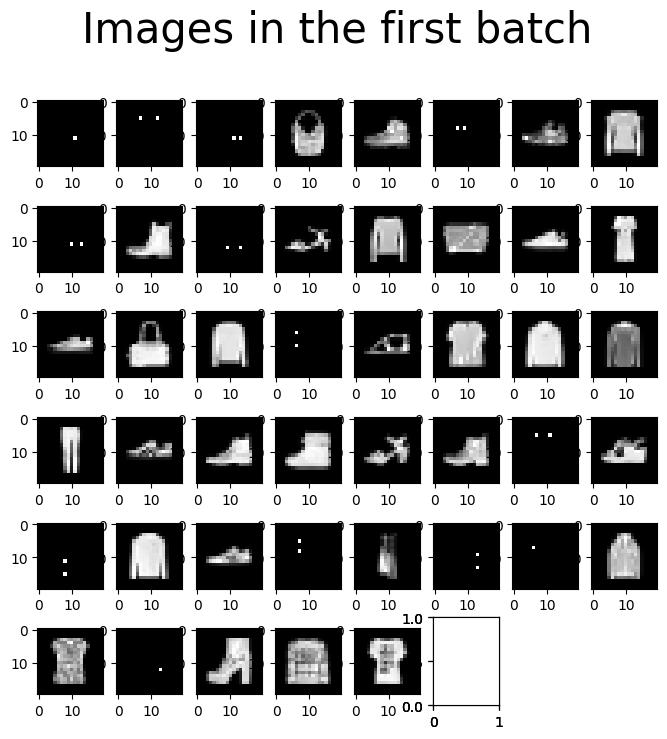

In [84]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                #np.save("./datasets/fmnist/"+str(idx)+".npy",images[idx][0])
                idx += 1
    fig.suptitle(title, fontsize=30)
    

    # Showing the figure
    plt.show()

def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break
    
# Optionally, show a batch of regular images
show_first_batch(loader)

In [205]:
import skimage
import random

print(len(loader))
ind=0
train_i=0
test_i=0
val_i=0
train_psnr=[]
test_psnr=[]
val_psnr=[]

def noise_mask(mask_size=12):
    mask=np.zeros((mask_size,mask_size))
    noise_mask=np.multiply(skimage.util.random_noise(mask,mode='salt'),np.random.rand(mask_size,mask_size))
    return noise_mask

def apply_mask(img,mask):
    img_l=img.shape[0]
    mask_l=mask.shape[0]
    edge=int((img_l-mask_l)/2)
    center=int(img_l/2)
    whole_mask=np.zeros((img_l,img_l))
    whole_mask[center-int(mask_l/2):center+int(mask_l/2),center-int(mask_l/2):center+int(mask_l/2)]=mask
    whole_mask=torch.tensor(whole_mask, dtype=torch.float32)
    x_shift = random.randint(-edge, edge)
    y_shift = random.randint(-edge, edge)
    whole_mask=torch.roll(whole_mask, shifts=(x_shift, y_shift), dims=(0, 1))
    
    return img+whole_mask

for batch in loader:
    for img_group in batch:
        #img_group=img_group.detach().cpu().numpy()
        print(img_group.shape)
        if len(img_group.shape)!=4:
            continue
        for i in range(img_group.shape[0]):
            img=img_group[i,:,:,:]
            img=np.reshape(img,(20,20))
            #fig=plt.figure()
            #plt.imshow(img, cmap="gray")
            noise=np.random.rand(20,20)*random.random()*0.2
            mask=noise_mask(12)
            
            #noised_img=apply_mask(img,mask)+noise
            #noised_img=np.array(img)+noise
            #noised_img=(noised_img - torch.min(noised_img)) / (torch.max(noised_img) - torch.min(noised_img))
            noise_amount=random.random()*0.1
            noised_img=skimage.util.random_noise(img,mode='s&p',amount=noise_amount)+noise
            #noised_img=(noised_img - np.min(noised_img)) / (np.max(noised_img) - np.min(noised_img))
            noised_img = torch.tensor(noised_img, dtype=torch.float32)
            #fig=plt.figure()
            #plt.imshow(noised_img, cmap="gray")
            psnr_score=psnr(noised_img,img)
            #print(psnr_score)
            
            if ind<450:
                train_i+=1
                train_psnr.append(psnr_score.detach().cpu().numpy())
                np.save('./datasets/psnr/train/'+str(train_i)+'.npy',noised_img.detach().cpu().numpy())
            elif ind<500:
                val_i+=1
                val_psnr.append(psnr_score)
                np.save('./datasets/psnr/val/'+str(val_i)+'.npy',noised_img.detach().cpu().numpy())
            else:
                test_i+=1
                test_psnr.append(psnr_score)
                np.save('./datasets/psnr/test/'+str(test_i)+'.npy',noised_img.detach().cpu().numpy())
        
    ind+=1
    

np.save('./datasets/psnr/train/label.npy',np.array(train_psnr))
np.save('./datasets/psnr/test/label.npy',np.array(test_psnr))
np.save('./datasets/psnr/val/label.npy',np.array(val_psnr))

545
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.

torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size

torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size([45, 1, 20, 20])
torch.Size([45])
torch.Size

In [215]:
import imageio

pattern='cup'
for i in range(1,6):
    input_image = imageio.v2.imread('E:/DIQA_CNN-master/DIQA_CNN-master/test_img/'+str(i)+'/'+pattern+'_'+str(i)+'.png',pilmode='L')
    input_image = (input_image-np.min(input_image)) / (np.max(input_image) - np.min(input_image))
    out_image=np.zeros((20,20))
    out_image[4:16,4:16] =input_image
    #plt.imshow(out_image)
    #print(out_image)
    np.save('./datasets/psnr/real_test/'+pattern+'_'+str(i)+'.npy',out_image)
    

In [2]:
import cv2

pattern='1'
for i in range(1,6):
    input_image = cv2.imread('E:/DIQA_CNN-master/DIQA_CNN-master/test_img/'+pattern+'_'+str(i)+'.png',cv2.IMREAD_GRAYSCALE)
    out_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2RGB)
    
    cv2.imwrite('E:/CLIP-IQA-2-3.8/demo/digits/'+pattern+'_'+str(i)+'.png',out_image)
    print('saved')

saved
saved
saved
saved
saved


## Traning with UNet with transformer

In [11]:
import scipy.constants as C

def A_distance_phasediff(d):
    metasurface_len=20
    metasurface_space=1
    f=79e9
    start_point_pos=torch.tensor([-30,0,0],dtype=torch.float32, device=device)
    start_point_pos=torch.unsqueeze(start_point_pos,dim=0)

    metasurface_position_y = torch.linspace(
        (metasurface_len-1)*metasurface_space/2, -(metasurface_len-1)*metasurface_space/2,  metasurface_len, dtype=torch.float32, device=device).expand(metasurface_len, metasurface_len)
    metasurface_position_z = torch.linspace(
        (metasurface_len-1)*metasurface_space/2, -(metasurface_len-1)*metasurface_space/2,  metasurface_len, dtype=torch.float32, device=device).expand(metasurface_len, metasurface_len).transpose(0, 1)
    metasurface_position = torch.stack((torch.zeros(metasurface_len, metasurface_len, dtype=torch.float32, device=device),
                                        metasurface_position_y,
                                        metasurface_position_z),
                                       dim=-1)

    metasurface_position = torch.flatten(
        metasurface_position, start_dim=0, end_dim=1)

    metasurface2_position = metasurface_position.clone()
    metasurface2_position[:, 0] = d

    dist_func = nn.PairwiseDistance(p=2)

    dist_metasurface = dist_func(
        metasurface_position.unsqueeze(0).expand(1, -1, -1),
        start_point_pos.unsqueeze(1).expand(-1, metasurface_len**2,  -1),
    )

    dist_metasurface2 = dist_func(
        metasurface2_position.unsqueeze(0).expand(1, -1, -1),
        start_point_pos.unsqueeze(1).expand(-1, metasurface_len**2,  -1),
    )

    h1=torch.exp(-1j*2*torch.pi*f*dist_metasurface/C.c)
    h2=torch.exp(-1j*2*torch.pi*f*dist_metasurface2/C.c)

    phase1=torch.angle(h1)
    phase2=torch.angle(h2)

    phase_diff=phase2-phase1
    
    return phase_diff

In [12]:
def A_noise(A,k,w):
    A=A.cpu()
    A_len=A.shape[-1]
    A_real=A[:,:,:int(A_len/2)]
    A_img=A[:,:,int(A_len/2):]
    A_complex=A_real+1j*A_img
    A_shifted=[]
    '''
    #k random phase shift
    for i in range(k):
        np.random.seed(k)
        rand_phase_mat=np.random.randn(A.shape[0],A.shape[1],int(A_len/2))*w
        A_shift=A_complex*np.exp(-1j*rand_phase_mat)
        A_shift = torch.concat([A_shift.real,A_shift.imag],dim=-1)
        A_shifted.append(A_shift.to(device).float())
    
    #k random amp shift
    for i in range(k):
        np.random.seed(k)
        rand_amp_mat=np.random.rand(A.shape[0],A.shape[1],int(A_len/2))*w+0.5
        A_shift=A_complex*rand_amp_mat
        A_shift = torch.concat([A_shift.real,A_shift.imag],dim=-1)
        A_shifted.append(A_shift.to(device).float())
        
    #k guassian noise
    for i in range(k):
        np.random.seed(k)
        guassian_real=np.random.randn(A.shape[0],A.shape[1],int(A_len/2))*w
        guassian_img=np.random.randn(A.shape[0],A.shape[1],int(A_len/2))*w
        A_shift=A_complex+guassian_real+1j*guassian_img
        A_shift = torch.concat([A_shift.real,A_shift.imag],dim=-1)
        A_shifted.append(A_shift.to(device).float())
    '''
    A_shifted.append(A.to(device).float())
    '''
    #different distance A phase change
    for d in range(1,6):
        phase_diff=A_distance_phasediff(d)
        phase_diff_mat=phase_diff.unsqueeze(-1).expand(-1,-1,int(A_len/2))
        A_shift=A_complex*np.exp(-1j*phase_diff_mat.cpu())
        A_shift=A_shift*np.exp(-1j*phase_diff_mat.cpu())
        A_shift = torch.concat([A_shift.real,A_shift.imag],dim=-1)
        A_shifted.append(A_shift.to(device).float())
    '''
    return A_shifted
    

In [13]:
A=dataset_sample.get_A().to(device).float()
A = A.permute(1,0)
A = A[None, :, :]
A_shifted=A_noise(A,5,1.2)
print(len(A_shifted))
print(A_shifted[0].shape)

1
torch.Size([1, 400, 11520])


In [14]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
#from ignite.metrics import PSNR,SSIM
import torch.nn.functional as F
from math import exp
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
'''
class PSNR:
    def __init__(self):
        self.data_range=255
        
    def forward(self,img1, img2):
        img1, img2 = img1.cpu().detach().numpy(), img2.cpu().detach().numpy()
        psnr=peak_signal_noise_ratio(img1, img2, data_range=self.data_range)
        
        return torch.Tensor(np.array(psnr))

class SSIM:
    def __init__(self):
        self.win_size=None
        self.gradient=False
        self.data_range=255
        self.multichannel=True
        self.guassian_weights=False
        self.full=False
    
    def forward(self,img1, img2):
        img1, img2 = img1.cpu().detach().numpy(), img2.cpu().detach().numpy()
        ssim=structural_similarity(img1, img2, win_size=self.win_size, gradient=self.gradient,
                                    data_range=self.data_range, multichannel=self.multichannel,
                                    guassian_weights=self.guassian_weights, full=self.full)
        
        return torch.Tensor(ssim)
'''
def psnr(generated, origin, max_val=1.0):
    mse = F.mse_loss(generated, origin)
    psnr = 20*torch.log10(max_val/torch.sqrt(mse))
    return psnr

'''
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window.cuda()

def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1
 
        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range
 
    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)
 
    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)
 
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
 
    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2
 
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2
 
    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity
 
    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)
 
    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)
 
    if full:
        return ret, cs
    return ret

# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range
 
        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)
 
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()
 
        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel
 
        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)
'''

'\ndef gaussian(window_size, sigma):\n    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])\n    return gauss/gauss.sum()\n\ndef create_window(window_size, channel=1):\n    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)\n    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)\n    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()\n    return window.cuda()\n\ndef ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):\n    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).\n    if val_range is None:\n        if torch.max(img1) > 128:\n            max_val = 255\n        else:\n            max_val = 1\n \n        if torch.min(img1) < -0.5:\n            min_val = -1\n        else:\n            min_val = 0\n        L = max_val - min_val\n    else:\n        L = val_range\n \n    padd = 0\n    (_, channel, he

In [15]:
def random_mask(x,mask_size):
    
    reflection_rate=random.uniform(0.1,1)
    
    mask_block=torch.ones((mask_size,mask_size))*reflection_rate
    mask=torch.ones((20,20))
    x_pos=random.randint(0, 20-mask_size)
    y_pos=random.randint(0, 20-mask_size)
    
    mask[x_pos:x_pos+mask_size,y_pos:y_pos+mask_size]=mask_block
    mask=mask.to(device).float()
    x_masked=x*mask
    
    return x_masked

def A_random_mask(A,mask_size):
    x_pos=random.randint(0, 20-mask_size)
    y_pos=random.randint(0, 20-mask_size)
    A=A.cpu()
    A_len=A.shape[-1]
    
    Amask=A[x_pos:x_pos+mask_size,y_pos:y_pos+mask_size,:]
    Amask_real=Amask[:,:,:int(A_len/2)]
    Amask_img=Amask[:,:,int(A_len/2):]
    Amask_complex=Amask_real+1j*Amask_img
    reflection_phaseshift=random.uniform(-3.14,3.14)
    reflection_rate=random.uniform(0.1,1)
    Amask_shift=Amask_complex*np.exp(-1j*reflection_phaseshift)*reflection_rate
    Amask_shift = torch.concat([Amask_shift.real,Amask_shift.imag],dim=-1)
    A[x_pos:x_pos+mask_size,y_pos:y_pos+mask_size,:]=Amask_shift
    
    A_masked=A.to(device).float()
    
    return A_masked
    


In [85]:
from torch.nn.utils import clip_grad_norm_

def training_loop(
    ddpm, loader, A, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"
):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps
    ssim = SSIM()
    max_grad_norm = 10
    '''
    A_shifted_set=[]
    
    for A in A_set:
        A = A.permute(1,0)
        A = A[None, :, :]
        A_shifted=A_noise(A,5,1.2)
        A_shifted_set.append(A_shifted)
    '''
    A = A.permute(1,0)
    A = A[None, :, :]
    A_shifted=A_noise(A,5,1.2)
    
    # TODO；
    # A_shifted[20]

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(
            tqdm(
                loader,
                leave=False,
                desc=f"Epoch {epoch + 1}/{n_epochs}",
                colour="#005500",
            )
        ):

            # Loading data
            x0 = batch[0].to(device)
            n = len(x0)

            # apply random mask
            x0_gt=x0.clone()
            '''
            mask_flag=random.random()
            if mask_flag>=0.6:
                mask_size=random.randint(8,12)
                x0=random_mask(x0,mask_size)
                '''
            #for A_shifted in A_shifted_set:
            # random_A_idx = torch.
            #A=random.choice(A_shifted)
            #A=A_shifted_set[step%30][0]
            
            A=random.choice(A_shifted)

            # apply random A masak
            '''
            mask_flag=random.random()
            if mask_flag>=0.5:
                mask_size=random.randint(5,15)
                A=A_random_mask(A,mask_size)
            '''
            A=A.repeat(n,1,1)

            y0 = x0.reshape(n, 1,-1) @ A    #TODO: A_new: 20种不同的A （5种相位漂移的A，5种幅度漂移的A，5种gaussian noise的A，5种幅度/相位的A）
            #print(y0.shape)
            #print(A.shape)
            y0 = torch.concat([A,y0],dim=1)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0_gt, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta,_ = ddpm.backward(noisy_imgs, y0, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            #ssim_loss = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=1)
            #loss = 1 - ssim_loss(eta_theta, eta)
            #loss = -psnr(eta_theta, eta)

            optim.zero_grad()
            loss.backward()

            #clip_grad_norm_(ddpm.parameters(), max_grad_norm)
            optim.step()
            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)



## Train

In [86]:
no_train = False
n_epochs = 500
lr = 0.001

n_steps, min_beta, max_beta = 1000, 10**-4, 0.02  # Originally used by the authors
'''
ddpm = MyDDPM(
    # MySigUNet(n_steps),     # normal case 
    # MySigUNetEmbedY(n_steps),     # t_embed case
    MySigUNetEmbedYPro(n_steps),            # t_embed with 10x layer
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device,
)
sum([p.numel() for p in ddpm.parameters()])

# Training
store_path = "conditional_ddpm_width192_t_embed_pro_fmnist.pt"
if not no_train:
    training_loop(
        ddpm,
        loader,
        dataset_sample.get_A().to(device).float(),
        n_epochs,
        optim=Adam(ddpm.parameters(), lr),
        device=device,
        store_path=store_path,
    )
'''
# temp
ddpm = MyDDPM(
    MySigUNet(n_steps),     # normal case 
    # MySigUNetEmbedY(n_steps),     # t_embed case
    # MySigUNetEmbedYPro(n_steps),            # t_embed with 10x layer
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device,
)
sum([p.numel() for p in ddpm.parameters()])
# Training
store_path = "conditional_ddpm_width192_fmnist_Ay_angres.pt"
A_train=dataset_As
if not no_train:
    training_loop(
        ddpm,
        loader,
        dataset_sample.get_A().to(device).float(),
        #A_train,
        n_epochs,
        optim=Adam(ddpm.parameters(), lr),
        device=device,
        store_path=store_path,
    )


Training progress:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 1: 0.296 --> Best model ever (stored)


Epoch 2/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 2: 0.068 --> Best model ever (stored)


Epoch 3/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 3: 0.051 --> Best model ever (stored)


Epoch 4/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 4: 0.043 --> Best model ever (stored)


Epoch 5/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 5: 0.039 --> Best model ever (stored)


Epoch 6/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 6: 0.039 --> Best model ever (stored)


Epoch 7/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 7: 0.034 --> Best model ever (stored)


Epoch 8/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 8: 0.033 --> Best model ever (stored)


Epoch 9/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 9: 0.031 --> Best model ever (stored)


Epoch 10/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 10: 0.032


Epoch 11/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 11: 0.030 --> Best model ever (stored)


Epoch 12/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 12: 0.029 --> Best model ever (stored)


Epoch 13/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 13: 0.029 --> Best model ever (stored)


Epoch 14/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 14: 0.028 --> Best model ever (stored)


Epoch 15/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 15: 0.029


Epoch 16/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 16: 0.026 --> Best model ever (stored)


Epoch 17/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 17: 0.026 --> Best model ever (stored)


Epoch 18/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 18: 0.027


Epoch 19/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 19: 0.025 --> Best model ever (stored)


Epoch 20/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 20: 0.025


Epoch 21/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 21: 0.024 --> Best model ever (stored)


Epoch 22/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 22: 0.024 --> Best model ever (stored)


Epoch 23/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 23: 0.024


Epoch 24/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 24: 0.023 --> Best model ever (stored)


Epoch 25/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 25: 0.024


Epoch 26/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 26: 0.023 --> Best model ever (stored)


Epoch 27/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 27: 0.023 --> Best model ever (stored)


Epoch 28/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 28: 0.023 --> Best model ever (stored)


Epoch 29/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 29: 0.022 --> Best model ever (stored)


Epoch 30/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 30: 0.022


Epoch 31/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 31: 0.022


Epoch 32/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 32: 0.022


Epoch 33/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 33: 0.021 --> Best model ever (stored)


Epoch 34/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 34: 0.021


Epoch 35/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 35: 0.021


Epoch 36/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 36: 0.021


Epoch 37/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 37: 0.021


Epoch 38/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 38: 0.020 --> Best model ever (stored)


Epoch 39/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 39: 0.021


Epoch 40/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 40: 0.020 --> Best model ever (stored)


Epoch 41/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 41: 0.020 --> Best model ever (stored)


Epoch 42/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 42: 0.021


Epoch 43/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 43: 0.020 --> Best model ever (stored)


Epoch 44/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 44: 0.020


Epoch 45/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 45: 0.020


Epoch 46/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 46: 0.019 --> Best model ever (stored)


Epoch 47/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 47: 0.019


Epoch 48/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 48: 0.019


Epoch 49/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 49: 0.019


Epoch 50/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 50: 0.018 --> Best model ever (stored)


Epoch 51/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 51: 0.019


Epoch 52/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 52: 0.019


Epoch 53/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 53: 0.018 --> Best model ever (stored)


Epoch 54/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 54: 0.018


Epoch 55/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 55: 0.018


Epoch 56/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 56: 0.021


Epoch 57/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 57: 0.018


Epoch 58/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 58: 0.017 --> Best model ever (stored)


Epoch 59/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 59: 0.019


Epoch 60/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 60: 0.018


Epoch 61/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 61: 0.017 --> Best model ever (stored)


Epoch 62/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 62: 0.016 --> Best model ever (stored)


Epoch 63/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 63: 0.016


Epoch 64/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 64: 0.017


Epoch 65/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 65: 0.016


Epoch 66/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 66: 0.017


Epoch 67/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 67: 0.016 --> Best model ever (stored)


Epoch 68/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 68: 0.016 --> Best model ever (stored)


Epoch 69/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 69: 0.015 --> Best model ever (stored)


Epoch 70/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 70: 0.016


Epoch 71/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 71: 0.016


Epoch 72/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 72: 0.016


Epoch 73/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 73: 0.016


Epoch 74/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 74: 0.015 --> Best model ever (stored)


Epoch 75/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 75: 0.016


Epoch 76/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 76: 0.015


Epoch 77/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 77: 0.016


Epoch 78/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 78: 0.015


Epoch 79/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 79: 0.015 --> Best model ever (stored)


Epoch 80/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 80: 0.015


Epoch 81/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 81: 0.015


Epoch 82/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 82: 0.015


Epoch 83/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 83: 0.015 --> Best model ever (stored)


Epoch 84/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 84: 0.015


Epoch 85/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 85: 0.015


Epoch 86/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 86: 0.015 --> Best model ever (stored)


Epoch 87/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 87: 0.015


Epoch 88/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 88: 0.014 --> Best model ever (stored)


Epoch 89/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 89: 0.014


Epoch 90/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 90: 0.014


Epoch 91/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 91: 0.014


Epoch 92/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 92: 0.014


Epoch 93/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 93: 0.014


Epoch 94/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 94: 0.014


Epoch 95/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 95: 0.014


Epoch 96/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 96: 0.014


Epoch 97/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 97: 0.014


Epoch 98/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 98: 0.015


Epoch 99/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 99: 0.014


Epoch 100/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 100: 0.014


Epoch 101/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 101: 0.015


Epoch 102/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 102: 0.012 --> Best model ever (stored)


Epoch 103/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 103: 0.014


Epoch 104/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 104: 0.013


Epoch 105/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 105: 0.013


Epoch 106/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 106: 0.013


Epoch 107/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 107: 0.012


Epoch 108/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 108: 0.013


Epoch 109/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 109: 0.013


Epoch 110/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 110: 0.013


Epoch 111/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 111: 0.014


Epoch 112/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 112: 0.013


Epoch 113/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 113: 0.014


Epoch 114/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 114: 0.013


Epoch 115/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 115: 0.013


Epoch 116/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 116: 0.013


Epoch 117/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 117: 0.012 --> Best model ever (stored)


Epoch 118/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 118: 0.013


Epoch 119/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 119: 0.012 --> Best model ever (stored)


Epoch 120/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 120: 0.013


Epoch 121/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 121: 0.012


Epoch 122/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 122: 0.013


Epoch 123/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 123: 0.013


Epoch 124/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 124: 0.013


Epoch 125/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 125: 0.012


Epoch 126/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 126: 0.013


Epoch 127/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 127: 0.012


Epoch 128/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 128: 0.013


Epoch 129/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 129: 0.013


Epoch 130/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 130: 0.012


Epoch 131/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 131: 0.012


Epoch 132/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 132: 0.012


Epoch 133/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 133: 0.012


Epoch 134/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 134: 0.012


Epoch 135/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 135: 0.012


Epoch 136/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 136: 0.012


Epoch 137/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 137: 0.012


Epoch 138/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 138: 0.012


Epoch 139/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 139: 0.012


Epoch 140/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 140: 0.012


Epoch 141/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 141: 0.012


Epoch 142/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 142: 0.011 --> Best model ever (stored)


Epoch 143/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 143: 0.011 --> Best model ever (stored)


Epoch 144/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 144: 0.011


Epoch 145/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 145: 0.011


Epoch 146/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 146: 0.012


Epoch 147/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 147: 0.013


Epoch 148/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 148: 0.012


Epoch 149/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 149: 0.012


Epoch 150/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 150: 0.011 --> Best model ever (stored)


Epoch 151/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 151: 0.011 --> Best model ever (stored)


Epoch 152/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 152: 0.011


Epoch 153/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 153: 0.012


Epoch 154/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 154: 0.011


Epoch 155/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 155: 0.011


Epoch 156/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 156: 0.011


Epoch 157/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 157: 0.012


Epoch 158/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 158: 0.012


Epoch 159/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 159: 0.012


Epoch 160/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 160: 0.011


Epoch 161/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 161: 0.011


Epoch 162/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 162: 0.011


Epoch 163/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 163: 0.012


Epoch 164/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 164: 0.011


Epoch 165/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 165: 0.010 --> Best model ever (stored)


Epoch 166/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 166: 0.010


Epoch 167/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 167: 0.011


Epoch 168/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 168: 0.011


Epoch 169/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 169: 0.012


Epoch 170/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 170: 0.011


Epoch 171/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 171: 0.011


Epoch 172/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 172: 0.012


Epoch 173/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 173: 0.011


Epoch 174/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 174: 0.011


Epoch 175/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 175: 0.011


Epoch 176/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 176: 0.011


Epoch 177/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 177: 0.010 --> Best model ever (stored)


Epoch 178/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 178: 0.011


Epoch 179/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 179: 0.011


Epoch 180/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 180: 0.011


Epoch 181/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 181: 0.011


Epoch 182/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 182: 0.011


Epoch 183/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 183: 0.011


Epoch 184/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 184: 0.010 --> Best model ever (stored)


Epoch 185/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 185: 0.011


Epoch 186/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 186: 0.011


Epoch 187/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 187: 0.010


Epoch 188/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 188: 0.011


Epoch 189/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 189: 0.011


Epoch 190/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 190: 0.010


Epoch 191/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 191: 0.010


Epoch 192/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 192: 0.011


Epoch 193/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 193: 0.011


Epoch 194/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 194: 0.010


Epoch 195/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 195: 0.011


Epoch 196/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 196: 0.010


Epoch 197/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 197: 0.010


Epoch 198/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 198: 0.010


Epoch 199/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 199: 0.011


Epoch 200/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 200: 0.010


Epoch 201/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 201: 0.010


Epoch 202/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 202: 0.010


Epoch 203/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 203: 0.010


Epoch 204/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 204: 0.010


Epoch 205/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 205: 0.010


Epoch 206/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 206: 0.010


Epoch 207/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 207: 0.010


Epoch 208/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 208: 0.011


Epoch 209/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 209: 0.010


Epoch 210/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 210: 0.011


Epoch 211/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 211: 0.009 --> Best model ever (stored)


Epoch 212/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 212: 0.010


Epoch 213/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 213: 0.010


Epoch 214/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 214: 0.011


Epoch 215/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 215: 0.010


Epoch 216/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 216: 0.010


Epoch 217/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 217: 0.010


Epoch 218/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 218: 0.010


Epoch 219/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 219: 0.010


Epoch 220/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 220: 0.012


Epoch 221/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 221: 0.010


Epoch 222/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 222: 0.010


Epoch 223/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 223: 0.010


Epoch 224/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 224: 0.011


Epoch 225/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 225: 0.010


Epoch 226/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 226: 0.010


Epoch 227/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 227: 0.009


Epoch 228/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 228: 0.010


Epoch 229/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 229: 0.010


Epoch 230/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 230: 0.010


Epoch 231/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 231: 0.010


Epoch 232/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 232: 0.009 --> Best model ever (stored)


Epoch 233/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 233: 0.010


Epoch 234/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 234: 0.009


Epoch 235/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 235: 0.010


Epoch 236/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 236: 0.010


Epoch 237/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 237: 0.010


Epoch 238/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 238: 0.010


Epoch 239/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 239: 0.009


Epoch 240/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 240: 0.010


Epoch 241/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 241: 0.009 --> Best model ever (stored)


Epoch 242/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 242: 0.010


Epoch 243/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 243: 0.010


Epoch 244/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 244: 0.010


Epoch 245/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 245: 0.010


Epoch 246/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 246: 0.009


Epoch 247/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 247: 0.010


Epoch 248/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 248: 0.010


Epoch 249/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 249: 0.010


Epoch 250/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 250: 0.010


Epoch 251/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 251: 0.010


Epoch 252/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 252: 0.010


Epoch 253/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 253: 0.011


Epoch 254/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 254: 0.009 --> Best model ever (stored)


Epoch 255/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 255: 0.011


Epoch 256/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 256: 0.009


Epoch 257/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 257: 0.009


Epoch 258/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 258: 0.009


Epoch 259/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 259: 0.010


Epoch 260/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 260: 0.010


Epoch 261/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 261: 0.009


Epoch 262/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 262: 0.010


Epoch 263/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 263: 0.010


Epoch 264/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 264: 0.010


Epoch 265/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 265: 0.010


Epoch 266/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 266: 0.010


Epoch 267/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 267: 0.009 --> Best model ever (stored)


Epoch 268/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 268: 0.009


Epoch 269/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 269: 0.010


Epoch 270/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 270: 0.009 --> Best model ever (stored)


Epoch 271/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 271: 0.009


Epoch 272/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 272: 0.010


Epoch 273/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 273: 0.009


Epoch 274/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 274: 0.010


Epoch 275/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 275: 0.010


Epoch 276/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 276: 0.009


Epoch 277/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 277: 0.009


Epoch 278/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 278: 0.009 --> Best model ever (stored)


Epoch 279/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 279: 0.010


Epoch 280/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 280: 0.009


Epoch 281/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 281: 0.009


Epoch 282/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 282: 0.009 --> Best model ever (stored)


Epoch 283/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 283: 0.009


Epoch 284/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 284: 0.009


Epoch 285/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 285: 0.009


Epoch 286/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 286: 0.009


Epoch 287/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 287: 0.010


Epoch 288/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 288: 0.009


Epoch 289/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 289: 0.009


Epoch 290/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 290: 0.009


Epoch 291/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 291: 0.009 --> Best model ever (stored)


Epoch 292/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 292: 0.009


Epoch 293/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 293: 0.010


Epoch 294/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 294: 0.009 --> Best model ever (stored)


Epoch 295/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 295: 0.009


Epoch 296/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 296: 0.009


Epoch 297/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 297: 0.009


Epoch 298/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 298: 0.009


Epoch 299/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 299: 0.009


Epoch 300/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 300: 0.009


Epoch 301/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 301: 0.008 --> Best model ever (stored)


Epoch 302/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 302: 0.009


Epoch 303/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 303: 0.009


Epoch 304/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 304: 0.011


Epoch 305/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 305: 0.009


Epoch 306/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 306: 0.009


Epoch 307/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 307: 0.009


Epoch 308/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 308: 0.010


Epoch 309/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 309: 0.010


Epoch 310/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 310: 0.009


Epoch 311/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 311: 0.009


Epoch 312/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 312: 0.009


Epoch 313/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 313: 0.009


Epoch 314/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 314: 0.009


Epoch 315/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 315: 0.009


Epoch 316/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 316: 0.009


Epoch 317/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 317: 0.009


Epoch 318/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 318: 0.009


Epoch 319/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 319: 0.009


Epoch 320/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 320: 0.009


Epoch 321/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 321: 0.009


Epoch 322/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 322: 0.009


Epoch 323/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 323: 0.009


Epoch 324/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 324: 0.009


Epoch 325/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 325: 0.009


Epoch 326/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 326: 0.009


Epoch 327/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 327: 0.009


Epoch 328/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 328: 0.009


Epoch 329/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 329: 0.009


Epoch 330/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 330: 0.008 --> Best model ever (stored)


Epoch 331/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 331: 0.009


Epoch 332/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 332: 0.009


Epoch 333/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 333: 0.010


Epoch 334/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 334: 0.009


Epoch 335/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 335: 0.009


Epoch 336/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 336: 0.009


Epoch 337/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 337: 0.009


Epoch 338/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 338: 0.009


Epoch 339/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 339: 0.009


Epoch 340/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 340: 0.010


Epoch 341/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 341: 0.008


Epoch 342/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 342: 0.009


Epoch 343/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 343: 0.009


Epoch 344/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 344: 0.009


Epoch 345/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 345: 0.009


Epoch 346/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 346: 0.009


Epoch 347/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 347: 0.009


Epoch 348/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 348: 0.009


Epoch 349/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 349: 0.009


Epoch 350/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 350: 0.009


Epoch 351/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 351: 0.009


Epoch 352/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 352: 0.009


Epoch 353/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 353: 0.009


Epoch 354/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 354: 0.009


Epoch 355/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 355: 0.009


Epoch 356/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 356: 0.008


Epoch 357/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 357: 0.009


Epoch 358/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 358: 0.009


Epoch 359/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 359: 0.009


Epoch 360/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 360: 0.008 --> Best model ever (stored)


Epoch 361/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 361: 0.009


Epoch 362/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 362: 0.009


Epoch 363/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 363: 0.008 --> Best model ever (stored)


Epoch 364/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 364: 0.008


Epoch 365/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 365: 0.008


Epoch 366/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 366: 0.009


Epoch 367/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 367: 0.009


Epoch 368/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 368: 0.008 --> Best model ever (stored)


Epoch 369/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 369: 0.008


Epoch 370/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 370: 0.008


Epoch 371/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 371: 0.009


Epoch 372/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 372: 0.009


Epoch 373/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 373: 0.008


Epoch 374/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 374: 0.009


Epoch 375/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 375: 0.008


Epoch 376/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 376: 0.009


Epoch 377/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 377: 0.009


Epoch 378/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 378: 0.008


Epoch 379/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 379: 0.008


Epoch 380/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 380: 0.009


Epoch 381/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 381: 0.008


Epoch 382/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 382: 0.008


Epoch 383/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 383: 0.008


Epoch 384/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 384: 0.008


Epoch 385/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 385: 0.009


Epoch 386/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 386: 0.008 --> Best model ever (stored)


Epoch 387/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 387: 0.008


Epoch 388/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 388: 0.009


Epoch 389/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 389: 0.013


Epoch 390/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 390: 0.009


Epoch 391/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 391: 0.009


Epoch 392/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 392: 0.009


Epoch 393/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 393: 0.009


Epoch 394/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 394: 0.008


Epoch 395/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 395: 0.009


Epoch 396/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 396: 0.008


Epoch 397/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 397: 0.009


Epoch 398/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 398: 0.008


Epoch 399/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 399: 0.008


Epoch 400/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 400: 0.009


Epoch 401/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 401: 0.009


Epoch 402/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 402: 0.008


Epoch 403/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 403: 0.009


Epoch 404/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 404: 0.008


Epoch 405/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 405: 0.008


Epoch 406/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 406: 0.008


Epoch 407/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 407: 0.008


Epoch 408/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 408: 0.009


Epoch 409/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 409: 0.008


Epoch 410/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 410: 0.009


Epoch 411/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 411: 0.008


Epoch 412/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 412: 0.009


Epoch 413/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 413: 0.008


Epoch 414/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 414: 0.008


Epoch 415/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 415: 0.009


Epoch 416/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 416: 0.008


Epoch 417/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 417: 0.008


Epoch 418/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 418: 0.008


Epoch 419/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 419: 0.008 --> Best model ever (stored)


Epoch 420/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 420: 0.009


Epoch 421/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 421: 0.009


Epoch 422/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 422: 0.008


Epoch 423/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 423: 0.008


Epoch 424/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 424: 0.008


Epoch 425/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 425: 0.008


Epoch 426/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 426: 0.008


Epoch 427/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 427: 0.008


Epoch 428/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 428: 0.009


Epoch 429/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 429: 0.008


Epoch 430/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 430: 0.008


Epoch 431/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 431: 0.008


Epoch 432/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 432: 0.008


Epoch 433/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 433: 0.008


Epoch 434/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 434: 0.009


Epoch 435/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 435: 0.009


Epoch 436/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 436: 0.008


Epoch 437/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 437: 0.008


Epoch 438/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 438: 0.008


Epoch 439/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 439: 0.008 --> Best model ever (stored)


Epoch 440/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 440: 0.009


Epoch 441/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 441: 0.008


Epoch 442/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 442: 0.008


Epoch 443/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 443: 0.008


Epoch 444/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 444: 0.009


Epoch 445/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 445: 0.008


Epoch 446/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 446: 0.008


Epoch 447/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 447: 0.008


Epoch 448/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 448: 0.009


Epoch 449/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 449: 0.008


Epoch 450/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 450: 0.007 --> Best model ever (stored)


Epoch 451/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 451: 0.009


Epoch 452/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 452: 0.008


Epoch 453/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 453: 0.008


Epoch 454/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 454: 0.008


Epoch 455/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 455: 0.008


Epoch 456/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 456: 0.009


Epoch 457/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 457: 0.009


Epoch 458/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 458: 0.009


Epoch 459/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 459: 0.008


Epoch 460/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 460: 0.008


Epoch 461/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 461: 0.008


Epoch 462/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 462: 0.008


Epoch 463/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 463: 0.008


Epoch 464/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 464: 0.008


Epoch 465/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 465: 0.008


Epoch 466/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 466: 0.008


Epoch 467/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 467: 0.008


Epoch 468/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 468: 0.009


Epoch 469/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 469: 0.008


Epoch 470/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 470: 0.008


Epoch 471/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 471: 0.008


Epoch 472/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 472: 0.008


Epoch 473/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 473: 0.008


Epoch 474/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 474: 0.008


Epoch 475/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 475: 0.008


Epoch 476/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 476: 0.008


Epoch 477/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 477: 0.008


Epoch 478/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 478: 0.008


Epoch 479/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 479: 0.008


Epoch 480/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 480: 0.008


Epoch 481/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 481: 0.008


Epoch 482/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 482: 0.008


Epoch 483/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 483: 0.008


Epoch 484/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 484: 0.009


Epoch 485/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 485: 0.008


Epoch 486/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 486: 0.008


Epoch 487/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 487: 0.008


Epoch 488/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 488: 0.008


Epoch 489/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 489: 0.008


Epoch 490/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 490: 0.008


Epoch 491/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 491: 0.008


Epoch 492/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 492: 0.008


Epoch 493/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 493: 0.007 --> Best model ever (stored)


Epoch 494/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 494: 0.008


Epoch 495/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 495: 0.008


Epoch 496/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 496: 0.008


Epoch 497/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 497: 0.008


Epoch 498/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 498: 0.008


Epoch 499/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 499: 0.008


Epoch 500/500:   0%|          | 0/192 [00:00<?, ?it/s]

Loss at epoch 500: 0.009


## DDPM

In [19]:
def new_ddpm_sample(
        y,        
    ddpm,
    ddpm_steps = 100,
    device=None,
    c=1,
    h=20,
    w=20):
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(1, c, h, w).to(device)

        factor = ddpm.n_steps // ddpm_steps
        ddim_timestep_seq = np.asarray(list(range(0, ddpm.n_steps, factor)))
        # ddim_timestep_seq = ddim_timestep_seq + 1

        # for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
        for i in tqdm(reversed(range(0, ddpm_steps)), desc='sampling loop time step', total=ddpm_steps):
            time_tensor = (torch.ones(1, 1) * ddim_timestep_seq[i]).to(device).long()
            
            eta_theta,_ = ddpm.backward(x, y, time_tensor)

            # alpha_t = ddpm.alphas[t]
            # alpha_t_bar = ddpm.alpha_bars[t]
            alpha_t = ddpm.alphas[ddim_timestep_seq[i]]
            alpha_t_bar = ddpm.alpha_bars[ddim_timestep_seq[i]]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (
                x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta
            )

            # if t > 0:
            if ddim_timestep_seq[i] > 0:
                z = torch.randn(1, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                # beta_t = ddpm.betas[t]
                # sigma_t = beta_t.sqrt()
                beta_t = ddpm.betas[ddim_timestep_seq[i]]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

        normalized = x.clone()
        normalized -= torch.min(normalized)
        normalized *= 1 / torch.max(normalized)

        return normalized

## Load Model

In [87]:
width = 192
time_embed = False
trained_with_fmnist = True      # pure gt / gt+fashionmnist


prefix_model_name = "conditional_ddpm_width"
suffix_model_name = "_t_embed_pro_fmnist.pt" if time_embed else "_fmnist_Ay_angres.pt" if trained_with_fmnist else ".pt"
store_path = prefix_model_name + str(width) + suffix_model_name
print("Loading model: ", store_path)

n_steps, min_beta, max_beta = 1000, 10**-4, 0.02  # Originally used by the authors
unet_structure = MySigUNetEmbedYPro(n_steps) if time_embed else MySigUNet(n_steps)

best_model = MyDDPM(
    unet_structure,
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device,
)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")


Loading model:  conditional_ddpm_width192_fmnist_Ay_angres.pt
Model loaded


In [ ]:
# # store_path = "conditional_ddpm.pt"
# # store_path = "conditional_ddpm_width192_t_embed.pt"
# store_path = 'conditional_ddpm_width192_t_embed_pro_fmnist.pt'
# # store_path = "conditional_ddpm_width60.pt"
# # store_path = "conditional_ddpm_width192.pt"
# # store_path = "conditional_ddpm_width192_fmnist.pt"

# n_steps, min_beta, max_beta = 1000, 10**-4, 0.02  # Originally used by the authors
# best_model = MyDDPM(
#     # MySigUNet(n_steps),       # normal case
#     # MySigUNetEmbedY(n_steps),           # t_embed case
#     MySigUNetEmbedYPro(n_steps),            # t_embed with 10x layer
#     n_steps=n_steps,
#     min_beta=min_beta,
#     max_beta=max_beta,
#     device=device,
# )
# best_model.load_state_dict(torch.load(store_path, map_location=device))
# best_model.eval()
# print("Model loaded")

## DDPM Test with generated y

torch.Size([400, 11520])
torch.Size([1, 11520])
torch.Size([1, 401, 11520])


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

ssim tensor(0.9998, device='cuda:0')


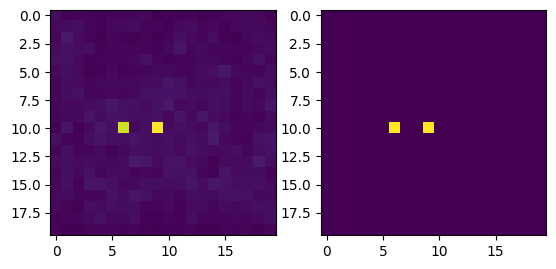

In [88]:
A = dataset_sample.get_A().to(device).float()
#A = A_train[0]
A=A.permute(1,0)
sample_num = 1
test_loader = DataLoader(dataset_number, 1, shuffle=True)
for data in test_loader:
    x,_ = data
    x=x.to(device).float()
    # gt = gt.reshape(1,1,20,20)
    #y = torch.matmul(A, x.reshape(-1,1)).reshape(1, -1).to(device)
    y = x.reshape(1,-1) @ A
    print(A.shape)
    print(y.shape)
    y = torch.concat([A,y],dim=0).unsqueeze(0)
    print(y.shape)
    sample_img = new_ddpm_sample(y, best_model, ddpm_steps=600)
    plt.figure()
    plt.subplot(121)
    plt.imshow(sample_img[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(x[0,0].detach().cpu().numpy())
    print("ssim",ssim(x,sample_img))
    sample_num -= 1

    if sample_num ==0:
        break

## DDPM Test with Real Y

  0%|          | 0/24 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0112, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0002, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0376, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0004, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0008, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0170, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0101, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0245, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0004, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0023, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0017, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0008, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0011, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0021, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0112, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0264, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0095, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0061, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0077, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0012, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0031, device='cuda:0')


C:\Users\87877\AppData\Local\Temp\ipykernel_36832\1670096739.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0086, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0024, device='cuda:0')


sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(0.0003, device='cuda:0')
horizontal_mse tensor(0.0123, device='cuda:0')
vertical_mse tensor(0.0343, device='cuda:0')
PSNR tensor(66.7407, device='cuda:0')


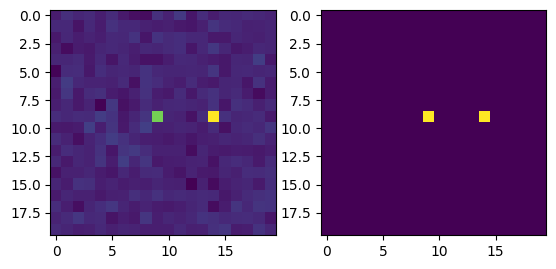

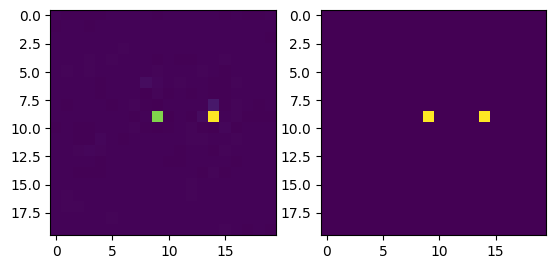

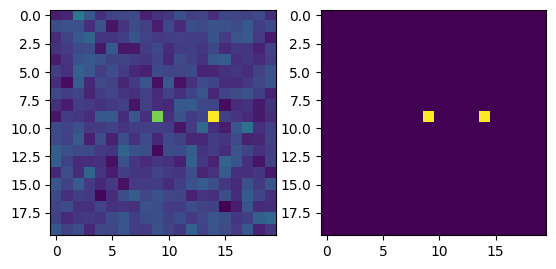

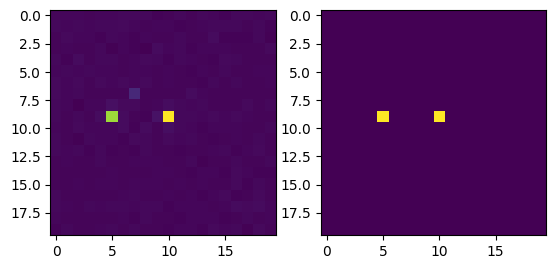

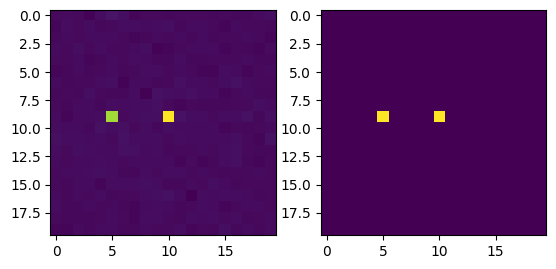

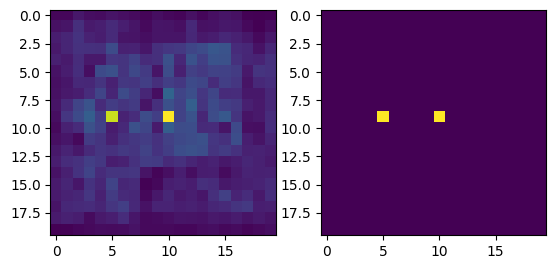

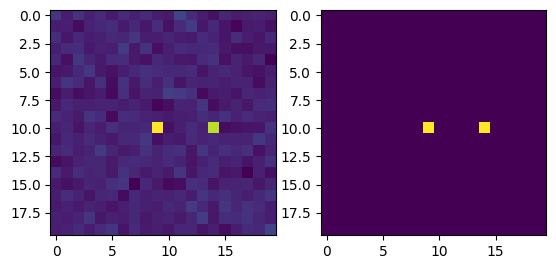

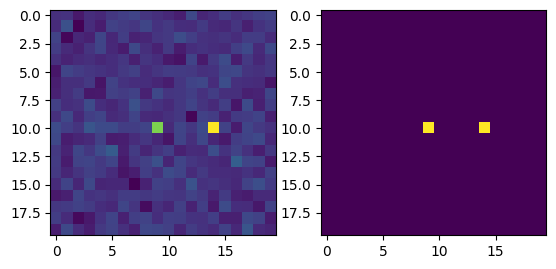

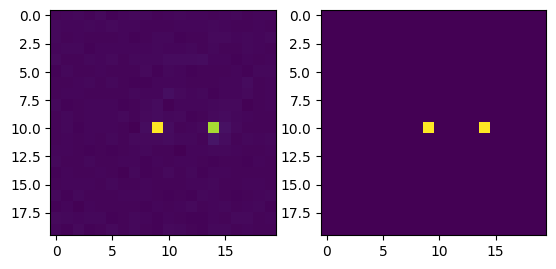

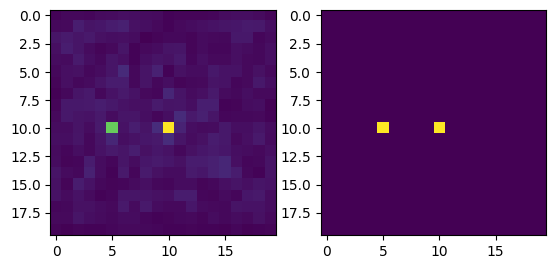

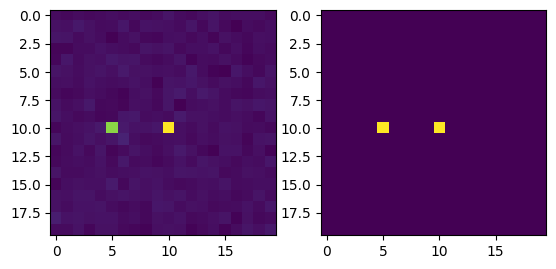

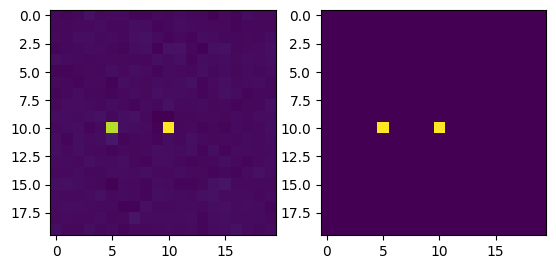

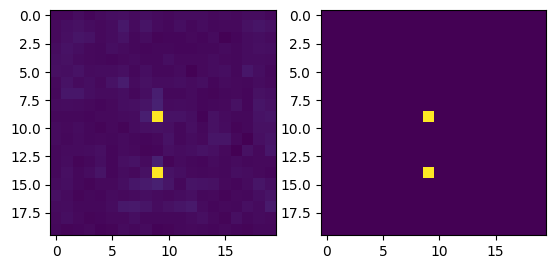

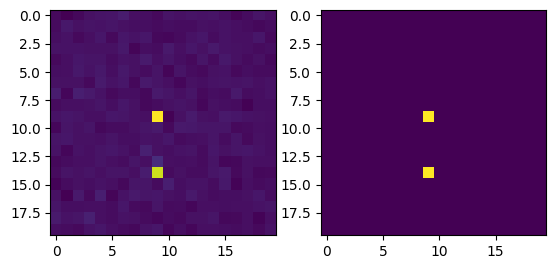

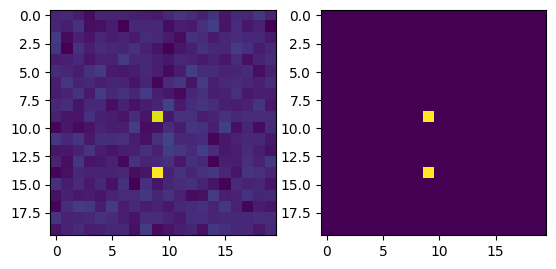

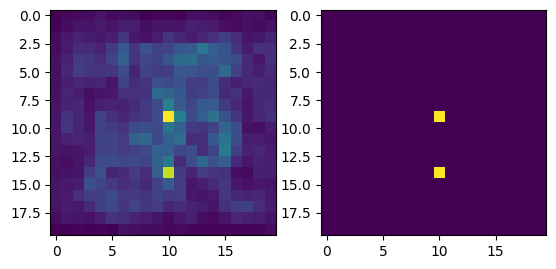

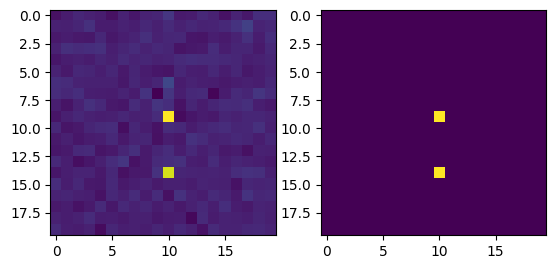

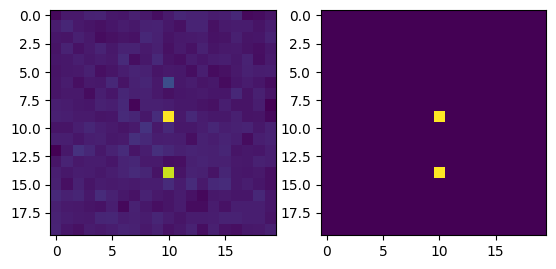

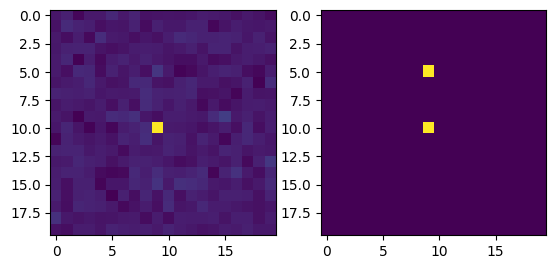

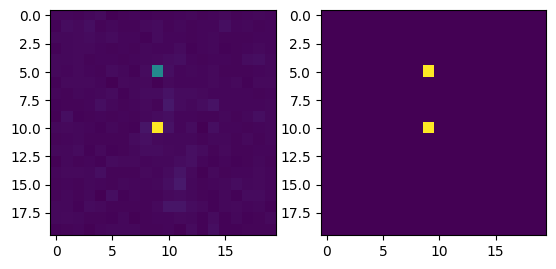

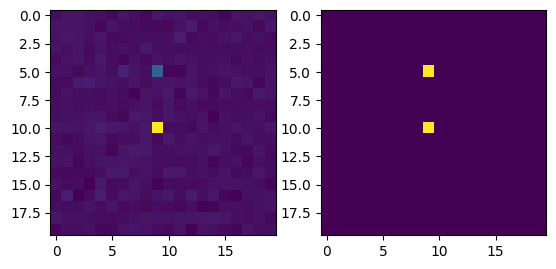

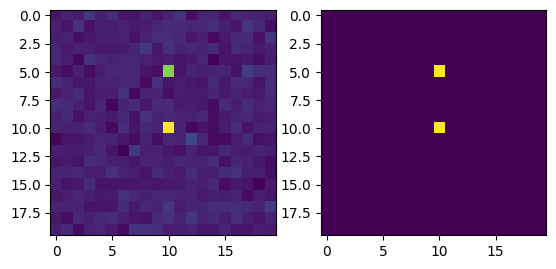

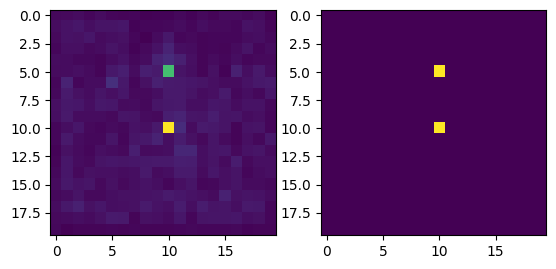

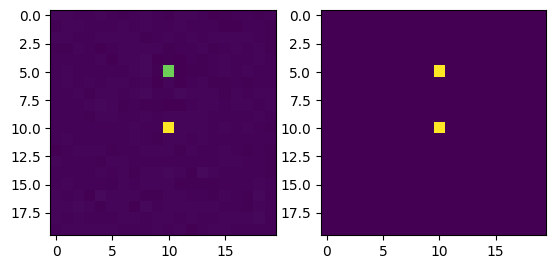

In [92]:
real_loader = DataLoader(dataset_sample, 1, shuffle=False)
A = dataset_sample.get_A().to(device).float()
A=A.permute(1,0)
sample_num = 9
sample_nums = sample_num
psnr_sum = 0
i=0
mse = nn.MSELoss()
mses=[]

for data in tqdm(real_loader):
    y,gt = data
    y,gt = y.to(device).float(),  gt.to(device).float()
    gt = gt.reshape(1,1,20,20)
    #y = torch.concat([A,y],dim=0).unsqueeze(0)
    sample_img = new_ddpm_sample(y, best_model, ddpm_steps=600)
    plt.figure()
    plt.subplot(121)
    plt.imshow(sample_img[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(gt[0][0].detach().cpu().numpy())
    sample_num -= 1
    psnr_sum += psnr(sample_img,gt)
    
    loss=mse(sample_img, gt)
    print(loss)
    mses.append(loss)
    
    #np.save("./datasets/data1118/result/pos_"+str(i)+".npy",sample_img[0,0].detach().cpu().numpy())
    i+=1

    #if sample_num ==0:
    #    break
    
horizontal_mse=sum(mses[:4])/4
vertical_mse=sum(mses[4:])/4
print("horizontal_mse",horizontal_mse)
print("vertical_mse",vertical_mse)

print("PSNR",psnr_sum/sample_nums)

  0%|          | 0/45 [00:00<?, ?it/s]

torch.Size([1, 1, 20, 20]) torch.Size([1, 11520]) torch.Size([1, 1])


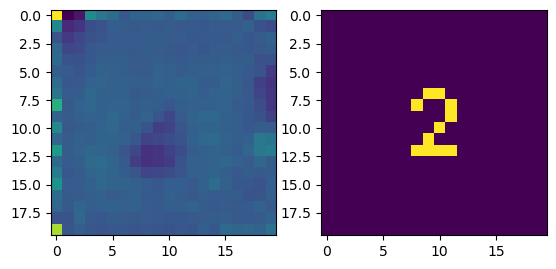

In [80]:
# A = torch.rand(11520,400).to(device)
real_loader = DataLoader(dataset_sample, 1, shuffle=True)
A = dataset_sample.get_A().to(device).float()
sample_num = 1

for data in tqdm(real_loader):
    y,gt = data
    y,gt = y.to(device).float(),  gt.to(device).float()
    gt = gt.reshape(1,1,20,20)
    print(gt.shape, y.shape, (torch.ones(1, 1) * 0).to(device).long().shape)
    _, out_y = best_model.network(gt, y, (torch.ones(1, 1) * 0).to(device).long())
    plt.figure()
    plt.subplot(121)
    plt.imshow(out_y[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(gt[0][0].detach().cpu().numpy())
    sample_num -= 1

    if sample_num ==0:
        break

## DDIM

In [12]:
def new_ddim_sample(
    diffusion,
    y,
    batch_size,
    image_size = 20,
    channels = 1,
    ddim_timesteps=10,
    diffusion_steps = 1000,
    ddim_eta=0.0,
    clip_denoised=True):

    c = diffusion_steps // ddim_timesteps
    ddim_timestep_seq = np.asarray(list(range(0, diffusion_steps, c)))
    ddim_timestep_seq = ddim_timestep_seq + 1
    ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
    sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)
#     model_kwargs = {"low_res": pred.to(device)}
    for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
        t = torch.full((batch_size,1), ddim_timestep_seq[i], device=device, dtype=torch.long)
        prev_t = torch.full((batch_size,1), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

        # 1. get current and previous alpha_cumprod
        # alpha_cumprod_t =  torch.tensor(diffusion.alphas_cumprod[ddim_timestep_seq[i]]).to(device) 
        # alpha_cumprod_t_prev = torch.tensor(diffusion.alphas_cumprod_prev[ddim_timestep_prev_seq[i]]).to(device)
        alpha_cumprod_t = diffusion.alpha_bars[t]
        alpha_cumprod_t_prev = diffusion.alpha_bars[prev_t] if t > 0 else diffusion.alphas[0]
        
        # 2. predict noise using model
        pred_noise, _ = diffusion.network(sample_img, y, t)

        # 3. get the predicted x_0
        pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
        
        if clip_denoised:
            pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)

        # 4. compute variance: "sigma_t(η)" -> see formula (16)
        # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        sigmas_t = ddim_eta * torch.sqrt((1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))

        # 5. compute "direction pointing to x_t" of formula (12)
        pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise

        # 6. compute x_{t-1} of formula (12)
        x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

        sample_img = x_prev

    sample_img -= torch.min(sample_img)
    sample_img *= 1 / torch.max(sample_img)

    return sample_img


In [18]:
torch.cuda.empty_cache()
import gc 
import time
gc.collect()
real_loader = DataLoader(dataset_sample, 1, shuffle=True)

## Test Real Signal with DDIM

  0%|          | 0/15 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

0.19680023193359375


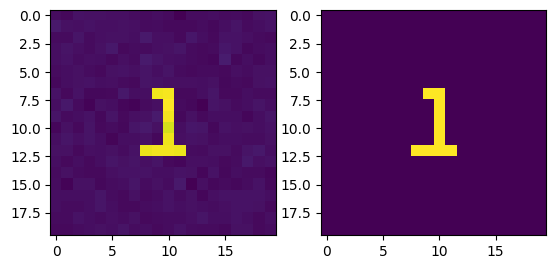

In [19]:
A = dataset_sample.get_A().to(device).float()
sample_num = 1

for data in tqdm(real_loader):
    y,gt = data
    y,gt = y.to(device).float(),  gt.to(device).float()
    gt = gt.reshape(1,1,20,20)
    t_0=time.time()
    sample_img = new_ddim_sample(best_model,y,
                          1,
                        image_size=20,
                        channels = 1,
                        ddim_timesteps= 10,   #
                        diffusion_steps = 1000,
                        ddim_eta=0.01,    # hyperparameter
                        clip_denoised=True)
    t_1=time.time()
    consume=t_1-t_0
    print(consume)
    plt.figure()
    plt.subplot(121)
    plt.imshow(sample_img[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(gt[0][0].detach().cpu().numpy())
    sample_num -= 1

    if sample_num ==0:
        break

## Red Diff with new diffusion model

In [168]:
def MyRedDiff(diffusion, 
            A,
              y,
                gt,
                start_x,
                ddim_eta=0.0,
                ):
    # normalization
    # y = y.permute(1,0) # 7680，32
    # _,B = y.shape
    B = 1
    
    x_init = torch.matmul(torch.linalg.pinv(A),y)# TODO: x_init.
    # x_init = torch.zeros_like(gt.reshape(B,-1).permute(1,0))
    x_init = torch.randn_like(x_init).to(x_init.device)
    

    mu_s = x_init.cpu()
    x0_pred_s = x_init.cpu()

    # x_pred = torch.autograd.Variable(x_init, requires_grad = True)  #400 32     # mu in code
    mu = torch.autograd.Variable(x_init, requires_grad = True)  #400 32     # mu in code

    # 1e-4
    # optimizer = torch.optim.Adam([x_pred], lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0)
    optimizer = torch.optim.Adam([mu], lr=1e-2, betas=(0.9, 0.99), weight_decay=0.0)
    schedular = torch.optim.lr_scheduler.StepLR(optimizer,400, gamma=0.5)
    Loss_history = []
    Loss_function = nn.MSELoss()
    
    lam = 0.01

    # TODO:?
    index_t = list(range(start_x))[::-1]
    for _ in range(1):
        index_t = index_t + list(range(start_x))[::-1]
    for i in tqdm(index_t):       
        t = torch.tensor([i] * B, device=device)
        t_tensor = torch.full((B,1), i, device=device, dtype=torch.long)

        # alpha_cumprod_t =  torch.tensor(diffusion.alphas_cumprod[ddim_timestep_seq[i]]).to(device) 
        # alpha_cumprod_t_prev = torch.tensor(diffusion.alphas_cumprod_prev[ddim_timestep_prev_seq[i]]).to(device)

        alpha_cumprod_t = diffusion.alpha_bars[i]
        alpha_cumprod_t_prev = diffusion.alpha_bars[i-1] if i > 0 else diffusion.alphas[0]
        sqrt_alphas_cumprod = torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alpha_cumprod_t)

        # yx new
        sigma_x0 = 0.0001
        noise_x0 = torch.randn_like(mu).to(mu.device) 
        noise_xt = torch.randn_like(mu).to(mu.device) 

        x0_pred = mu + sigma_x0 * noise_x0
        # x_t = diffusion.sqrt_alphas_cumprod[i] * x_pred + diffusion.sqrt_one_minus_alphas_cumprod[i] * noise_t # 400 32
        xt = sqrt_alphas_cumprod * x0_pred + sqrt_one_minus_alphas_cumprod * noise_xt # 400 32

        # # yx new
        # c1 = ((1-alpha_cumprod_t/alpha_cumprod_t_prev) * (1-alpha_cumprod_t_prev) / (1-alpha_cumprod_t)).sqrt() * ddim_eta
        # c2 = ((1-alpha_cumprod_t_prev) - c1**2 ).sqrt()
        
        # ### if cond_awd
        # # scale = alpha_cumprod_t_prev.sqrt() / (alpha_cumprod_t_prev.sqrt()-c2*alpha_cumprod_t.sqrt() / (1-alpha_cumprod_t.sqrt()))
        # ### else
        # scale = 1.0

        # eps_pred = diffusion.network(xt.reshape(B,1,20,20), t).reshape(-1)
        eps_pred, _ = diffusion.network(xt.reshape(B,1,20,20), y.reshape(1,-1), t_tensor)
        eps_pred = eps_pred.reshape(-1)
        x0_hat = (xt - torch.sqrt((1. - alpha_cumprod_t)) * eps_pred) / torch.sqrt(alpha_cumprod_t)
        
        ### if cond_awd
        # eps_pred = (xt - x0_hat * alpha_cumprod_t.sqrt()) / (1-alpha_cumprod_t.sqrt())
        ### else
        eps_pred = eps_pred.detach()
        #  eps_pred = eps_pred.reshape(B,-1).permute(1,0)

        e_obs = y - torch.matmul(A,x0_pred) 
        loss_obs = (e_obs ** 2).mean() / 2
        loss_noise = torch.mul((eps_pred-noise_xt).detach(), x0_pred).mean()      
        
        # snr_inv = (1-diffusion.alpha_bars[0]).sqrt() / diffusion.alpha_bars[0].sqrt()

        # w_t = self.grad_term_weight*snr_inv   #0.25
        # v_t = self.obs_weight
        # loss = w_t*loss_noise + v_t*loss_obs      
        loss = 1e2 * loss_noise +  lam * loss_obs     
        # loss = lam * loss_obs
        
        if i % 10 == 0 :
            print("Noise:{},obs:{}".format(loss_noise,loss_obs))
        Loss_history.append(Loss_function(mu,gt.reshape(B,-1).permute(1,0)).item())
        optimizer.zero_grad()  #initialize
        loss.backward()
        optimizer.step()

    schedular.step()
    plt.plot(Loss_history)
    plt.show()
    return mu.reshape(B,1,20,20)

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

d:\Applications\Anaconda\envs\leap-motion\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([400, 1])) that is different to the input size (torch.Size([400])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Noise:0.2949376702308655,obs:101632256.0
Noise:0.3012997508049011,obs:79630136.0
Noise:0.3093640208244324,obs:62691040.0
Noise:0.31127235293388367,obs:49915308.0
Noise:0.31792372465133667,obs:40328320.0
Noise:0.32115858793258667,obs:33055284.0
Noise:0.3279944956302643,obs:27456468.0
Noise:0.3317028880119324,obs:23080734.0
Noise:0.3486543595790863,obs:19613414.0
Noise:0.355151504278183,obs:16819570.0
Noise:0.35128334164619446,obs:14532768.0
Noise:0.3694824278354645,obs:12638331.0
Noise:0.37987783551216125,obs:11051335.0
Noise:0.3934723436832428,obs:9708903.0
Noise:0.3935531973838806,obs:8569112.0
Noise:0.410329133272171,obs:7594455.0
Noise:0.3960733711719513,obs:6758129.0
Noise:0.42118895053863525,obs:6036016.5
Noise:0.41219085454940796,obs:5410537.5
Noise:0.43448683619499207,obs:4864246.0
Noise:0.4417550563812256,obs:4385595.0
Noise:0.4430309236049652,obs:3964472.75
Noise:0.45000606775283813,obs:3591823.0
Noise:0.4500172436237335,obs:3259947.75
Noise:0.4808449447154999,obs:2964183.75
N

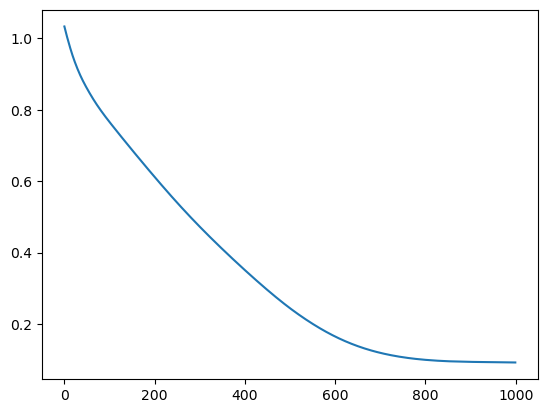

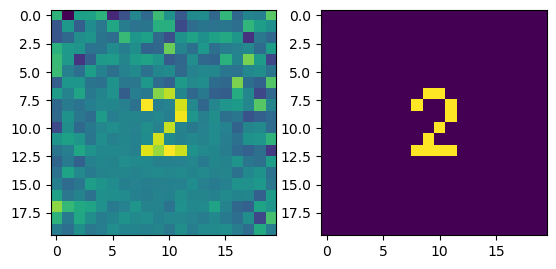

In [169]:
A = dataset_sample.get_A().to(device).float()
sample_num = 8


def MSE(pred,gt):
    mse=torch.mean(torch.square(pred-gt))
    return mse

A = dataset_sample.get_A().to(device).float()
# A = torch.randn_like(A).to(device)
for data in tqdm(real_loader):
    y,gt = data
    y,gt = y[0].to(device).float(),  gt[0].to(device).float()
    gt = gt.reshape(1,1,20,20)
    # y = A@ gt.reshape(-1,1)
    output = MyRedDiff(best_model,
                     A,    # 11520, 400
                            y,  # B, 11520
                            gt,     # B, 1, 20, 20
                            500,
                            ddim_eta=0.01
                            )    # 400 FOR DEFAULT
    break


# plt.imshow(torch.clamp(output[0, 0],0,1).detach().cpu().numpy())
plt.subplot(1,2,1)
plt.imshow(output[0,0].detach().cpu().numpy())
# plt.imshow((output[0,0].detach().cpu().numpy()))
# plt.imshow(torch.clamp(output[0, 0],0,1).detach().cpu().numpy())
# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(gt[0,0].detach().cpu().numpy())


## Test different Methods with drifted A/y

### Load Drift Dataset

In [114]:
class MyDataset(Dataset):
    def __init__(self, A_path, Y_path, gt_path):
        # load A
        A0 = torch.zeros(16*5*72,20,20,dtype=torch.complex128)
        for j in range(20):
            for i in range(20):
                path = "adc_data_"+str(20*j+i+1)+".mat"
                mat = scipy.io.loadmat(os.path.join(A_path,path))
                A_now = torch.from_numpy(mat["adcData1Complex"])
                #print(A_now)
                A_now = A_now[:,4:9,:]
                A_new = A_now.reshape(-1,1)
                A0[:,j,i] = A_new.reshape(-1)  
        A0 = A0.reshape(-1, 20**2)
        self.A = torch.concat([A0.real,A0.imag],dim=0)

        self.Y = []
        self.gt = []
        char = ['0','1','2','3','4','A','B','C','cup']
        for i in range(18):
            test = scipy.io.loadmat(os.path.join(Y_path,"adc_data_test"+char[i//2]+"_"+str(i%2+1)+".mat"))
            test=torch.from_numpy(test["adcData1Complex"]).to(torch.complex64)
            test = test[:,4:9,:] # 5x5
            test = test.reshape(-1)
            s_test = torch.concat([test.real,test.imag],dim=0).to(self.A.dtype)
            self.Y.append(s_test)

            gt = np.load(os.path.join(gt_path, 'gt_'+char[i//2]+'.npy'))
            gt = torch.tensor(gt, dtype=self.A.dtype)
            gt = gt.reshape(-1)
            self.gt.append(gt)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.Y[idx], self.gt[idx]

    def get_A(self):
        return self.A


A_path = './datasets/opt_cw_opt_mts/opt_cw_opt_mts/calibration'
Y_path = './datasets/0619occlusion'
gt_path = './datasets/gt_20x20/'
dataset_drift_sample = MyDataset(A_path, Y_path, gt_path)
drift_loader = DataLoader(dataset_drift_sample, 1, shuffle=True)
A = dataset_drift_sample.get_A().to(device).float()

### DDIM

  0%|          | 0/18 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/20 [00:00<?, ?it/s]

MSE: 0.021713805035687983
PSNR tensor(19.3776, device='cuda:0', grad_fn=<DivBackward0>)


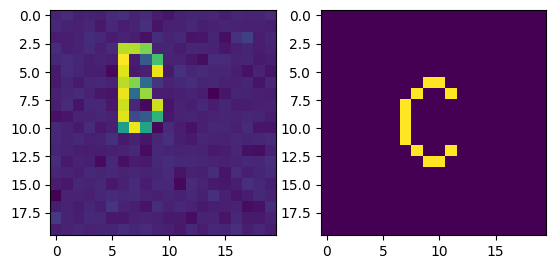

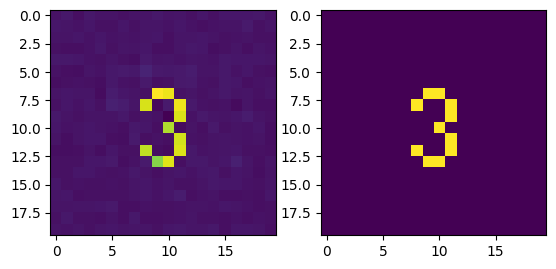

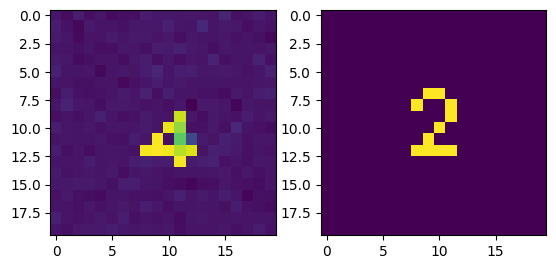

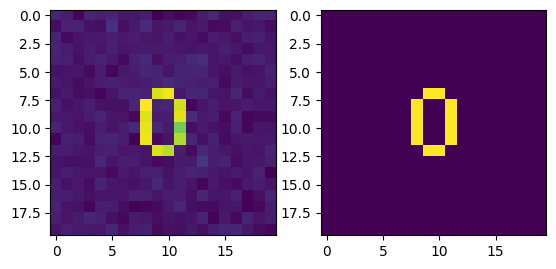

In [115]:
torch.cuda.empty_cache()
import gc 
gc.collect()

def MSE(pred,gt):
    mse=torch.mean(torch.square(pred-gt))
    return mse

sample_num = 4
cnt = 0

mse_sum = 0
psnr_sum = 0
for data in tqdm(drift_loader):
    y,gt = data
    y,gt = y.to(device).float(),  gt.to(device).float()
    gt = gt.reshape(1,1,20,20)
    sample_img = new_ddim_sample(best_model,y,
                          1,
                        image_size=20,
                        channels = 1,
                        ddim_timesteps= 20,
                        diffusion_steps = 1000,
                        ddim_eta=0.01,
                        clip_denoised=True)
    plt.figure()
    plt.subplot(121)
    plt.imshow(sample_img[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(gt[0][0].detach().cpu().numpy())
    mse_sum += MSE(sample_img,gt).detach().cpu().numpy()
    psnr_sum += psnr(sample_img,gt)
    cnt += 1

    if sample_num ==cnt:
        break
print("MSE:",mse_sum/sample_num)
print("PSNR",psnr_sum/sample_num)

### DDPM

  0%|          | 0/18 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/600 [00:00<?, ?it/s]

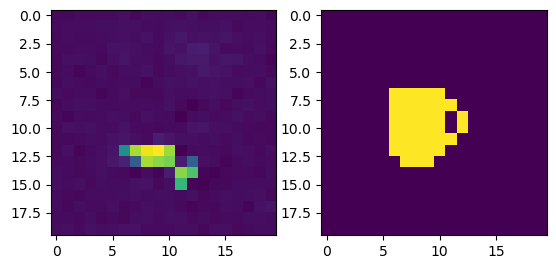

In [64]:
sample_num = 1

for data in tqdm(drift_loader):
    y,gt = data
    y,gt = y.to(device).float(),  gt.to(device).float()
    gt = gt.reshape(1,1,20,20)
    sample_img = new_ddpm_sample(y, best_model, ddpm_steps=600)
    plt.figure()
    plt.subplot(121)
    plt.imshow(sample_img[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(gt[0][0].detach().cpu().numpy())
    sample_num -= 1

    if sample_num ==0:
        break

### RED Diff

In [14]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 20, 20), 1, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10),
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 10, 10), 10, 20),
            MyBlock((20, 10, 10), 20, 20),
            MyBlock((20, 10, 10), 20, 20),
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 5, 5), 20, 40),
            MyBlock((40, 5, 5), 40, 40),
            MyBlock((40, 5, 5), 40, 40),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 2, 2), 40, 20),
            MyBlock((20, 2, 2), 20, 20),
            MyBlock((20, 2, 2), 20, 40),
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 5, 5), 80, 40),
            MyBlock((40, 5, 5), 40, 20),
            MyBlock((20, 5, 5), 20, 20),
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 10, 10), 40, 20),
            MyBlock((20, 10, 10), 20, 10),
            MyBlock((10, 10, 10), 10, 10),
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 20, 20), 20, 10),
            MyBlock((10, 20, 20), 10, 10),
            MyBlock((10, 20, 20), 10, 10, normalize=False),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(
            self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1)
        )  # (N, 20, 14, 14)
        out3 = self.b3(
            self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 7, 7)

        out_mid = self.b_mid(
            self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1)
        )  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out)
        )
    


def RedDiff(diffusion, 
            A,
              y,
                gt,
                start_x,
                ddim_eta=0.0,
                ):
    # normalization
    # y = y.permute(1,0) # 7680，32
    # _,B = y.shape
    B = 1
    
    x_init = torch.matmul(torch.linalg.pinv(A),y)# TODO: x_init.
    # x_init = torch.zeros_like(gt.reshape(B,-1).permute(1,0))
    x_init = torch.randn_like(x_init).to(x_init.device)
    

    mu_s = x_init.cpu()
    x0_pred_s = x_init.cpu()

    # x_pred = torch.autograd.Variable(x_init, requires_grad = True)  #400 32     # mu in code
    mu = torch.autograd.Variable(x_init, requires_grad = True)  #400 32     # mu in code

    # 1e-4
    # optimizer = torch.optim.Adam([x_pred], lr=1e-4, betas=(0.9, 0.99), weight_decay=0.0)
    optimizer = torch.optim.Adam([mu], lr=1e-2, betas=(0.9, 0.99), weight_decay=0.0)
    schedular = torch.optim.lr_scheduler.StepLR(optimizer,400, gamma=0.5)
    Loss_history = []
    Loss_function = nn.MSELoss()
    
    lam = 0.01

    # TODO:?
    index_t = list(range(start_x))[::-1]
    for _ in range(1):
        index_t = index_t + list(range(start_x))[::-1]
    for i in tqdm(index_t):       
        t = torch.tensor([i] * B, device=device)

        # alpha_cumprod_t =  torch.tensor(diffusion.alphas_cumprod[ddim_timestep_seq[i]]).to(device) 
        # alpha_cumprod_t_prev = torch.tensor(diffusion.alphas_cumprod_prev[ddim_timestep_prev_seq[i]]).to(device)

        alpha_cumprod_t = diffusion.alpha_bars[i]
        alpha_cumprod_t_prev = diffusion.alpha_bars[i-1] if i > 0 else diffusion.alphas[0]
        sqrt_alphas_cumprod = torch.sqrt(alpha_cumprod_t)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alpha_cumprod_t)

        # yx new
        sigma_x0 = 0.0001
        noise_x0 = torch.randn_like(mu).to(mu.device) 
        noise_xt = torch.randn_like(mu).to(mu.device) 

        x0_pred = mu + sigma_x0 * noise_x0
        # x_t = diffusion.sqrt_alphas_cumprod[i] * x_pred + diffusion.sqrt_one_minus_alphas_cumprod[i] * noise_t # 400 32
        xt = sqrt_alphas_cumprod * x0_pred + sqrt_one_minus_alphas_cumprod * noise_xt # 400 32

        # # yx new
        # c1 = ((1-alpha_cumprod_t/alpha_cumprod_t_prev) * (1-alpha_cumprod_t_prev) / (1-alpha_cumprod_t)).sqrt() * ddim_eta
        # c2 = ((1-alpha_cumprod_t_prev) - c1**2 ).sqrt()
        
        # ### if cond_awd
        # # scale = alpha_cumprod_t_prev.sqrt() / (alpha_cumprod_t_prev.sqrt()-c2*alpha_cumprod_t.sqrt() / (1-alpha_cumprod_t.sqrt()))
        # ### else
        # scale = 1.0

        eps_pred = diffusion.network(xt.reshape(B,1,20,20), t).reshape(-1)
        x0_hat = (xt - torch.sqrt((1. - alpha_cumprod_t)) * eps_pred) / torch.sqrt(alpha_cumprod_t)
        
        ### if cond_awd
        # eps_pred = (xt - x0_hat * alpha_cumprod_t.sqrt()) / (1-alpha_cumprod_t.sqrt())
        ### else
        eps_pred = eps_pred.detach()
        #  eps_pred = eps_pred.reshape(B,-1).permute(1,0)

        e_obs = y - torch.matmul(A,x0_pred) 
        loss_obs = (e_obs ** 2).mean() / 2
        loss_noise = torch.mul((eps_pred-noise_xt).detach(), x0_pred).mean()      
        
        # snr_inv = (1-diffusion.alpha_bars[0]).sqrt() / diffusion.alpha_bars[0].sqrt()

        # w_t = self.grad_term_weight*snr_inv   #0.25
        # v_t = self.obs_weight
        # loss = w_t*loss_noise + v_t*loss_obs      
        loss = 1e2 * loss_noise +  lam * loss_obs     
        # loss = lam * loss_obs
        
        if i % 10 == 0 :
            print("Noise:{},obs:{}".format(loss_noise,loss_obs))
        Loss_history.append(Loss_function(mu,gt.reshape(B,-1).permute(1,0)).item())
        optimizer.zero_grad()  #initialize
        loss.backward()
        optimizer.step()

    schedular.step()
    plt.figure()
    plt.plot(Loss_history)
    plt.show()
    return mu.reshape(B,1,20,20)

In [27]:
# store_path = "ddpm_only_gt_100epochs_shifted.pt" if fashion else "ddpm_mnist.pt"
# store_path = "ddpm_only_gt_100epochs_shifted_0to1.pt"       # 训练集 (-1 , 1)  测试集 (0, 1)
store_path = "ddpm_fashion_gt_100epochs_size11_padding.pt"

n_steps, min_beta, max_beta = 1000, 10**-4, 0.02  # Originally used by the authors
best_model = MyDDPM(
    MyUNet(n_steps),
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    device=device,
)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

d:\Applications\Anaconda\envs\leap-motion\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([400, 1])) that is different to the input size (torch.Size([400])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Noise:0.6088671088218689,obs:81306344.0
Noise:0.619257390499115,obs:60564764.0
Noise:0.6111778616905212,obs:47079964.0
Noise:0.6409387588500977,obs:38248864.0
Noise:0.6136036515235901,obs:32050416.0
Noise:0.6153706908226013,obs:27396214.0
Noise:0.5722989439964294,obs:23778182.0
Noise:0.6489449739456177,obs:20883628.0
Noise:0.6522151231765747,obs:18510640.0
Noise:0.6079987287521362,obs:16527545.0
Noise:0.6024503707885742,obs:14843728.0
Noise:0.6284958124160767,obs:13394930.0
Noise:0.5780539512634277,obs:12138255.0
Noise:0.6870384812355042,obs:11041997.0
Noise:0.6752668023109436,obs:10080734.0
Noise:0.6604645252227783,obs:9233460.0
Noise:0.5973844528198242,obs:8484686.0
Noise:0.6407155394554138,obs:7820725.5
Noise:0.6511478424072266,obs:7231189.5
Noise:0.71101975440979,obs:6706637.5
Noise:0.6802660822868347,obs:6238717.5
Noise:0.7190475463867188,obs:5820279.5
Noise:0.6869175434112549,obs:5445598.5
Noise:0.6465945839881897,obs:5109880.5
Noise:0.6818283200263977,obs:4807713.0
Noise:0.73194

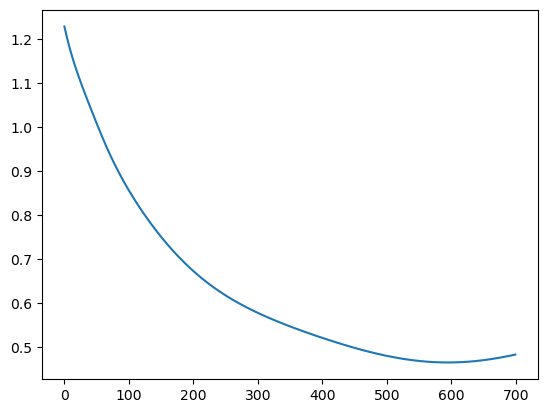

  0%|          | 0/700 [00:00<?, ?it/s]

Noise:0.5068737864494324,obs:100730632.0
Noise:0.5320449471473694,obs:71630056.0
Noise:0.5247412919998169,obs:54763072.0
Noise:0.5895130634307861,obs:44200484.0
Noise:0.5670378804206848,obs:36575036.0
Noise:0.5801761746406555,obs:30782184.0
Noise:0.5463884472846985,obs:26287014.0
Noise:0.611868143081665,obs:22693952.0
Noise:0.5480744242668152,obs:19781230.0
Noise:0.5832030177116394,obs:17399384.0
Noise:0.5948317646980286,obs:15427249.0
Noise:0.5913601517677307,obs:13773878.0
Noise:0.64997398853302,obs:12372068.0
Noise:0.6635155081748962,obs:11171143.0
Noise:0.6242201328277588,obs:10132638.0
Noise:0.6137917041778564,obs:9228751.0
Noise:0.5856221914291382,obs:8436720.0
Noise:0.583979070186615,obs:7737959.5
Noise:0.6665086150169373,obs:7120557.5
Noise:0.6549333333969116,obs:6571696.5
Noise:0.6154865622520447,obs:6082570.0
Noise:0.6263856291770935,obs:5645635.5
Noise:0.7084089517593384,obs:5253149.5
Noise:0.6996103525161743,obs:4900011.0
Noise:0.6794511079788208,obs:4581796.5
Noise:0.62891

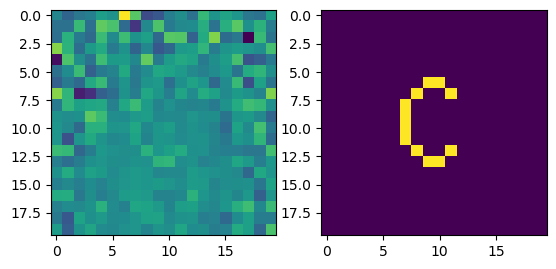

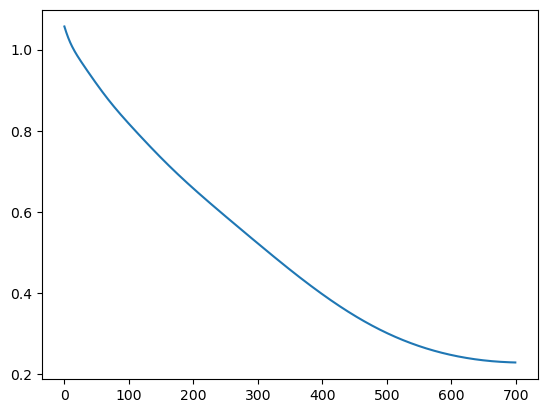

  0%|          | 0/700 [00:00<?, ?it/s]

Noise:0.532762885093689,obs:82000992.0
Noise:0.5648452043533325,obs:63259116.0
Noise:0.4868316948413849,obs:49960564.0
Noise:0.5185673236846924,obs:40333976.0
Noise:0.5416439175605774,obs:32998508.0
Noise:0.5540096759796143,obs:27338496.0
Noise:0.5046229958534241,obs:22964080.0
Noise:0.5588259100914001,obs:19567148.0
Noise:0.5737585425376892,obs:16910872.0
Noise:0.5657120943069458,obs:14804948.0
Noise:0.5792708992958069,obs:13107314.0
Noise:0.6360563039779663,obs:11716462.0
Noise:0.5778846740722656,obs:10556056.0
Noise:0.5840876698493958,obs:9574665.0
Noise:0.6569691896438599,obs:8735818.0
Noise:0.618698239326477,obs:8011972.5
Noise:0.6673048138618469,obs:7381815.5
Noise:0.6350061893463135,obs:6831201.0
Noise:0.6671546101570129,obs:6346219.0
Noise:0.6244941353797913,obs:5917411.0
Noise:0.7034618854522705,obs:5535820.0
Noise:0.634451687335968,obs:5195402.5
Noise:0.6628301739692688,obs:4888989.0
Noise:0.6608282327651978,obs:4613584.0
Noise:0.6441890001296997,obs:4363505.0
Noise:0.7011845

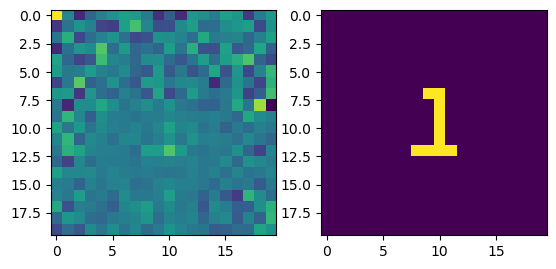

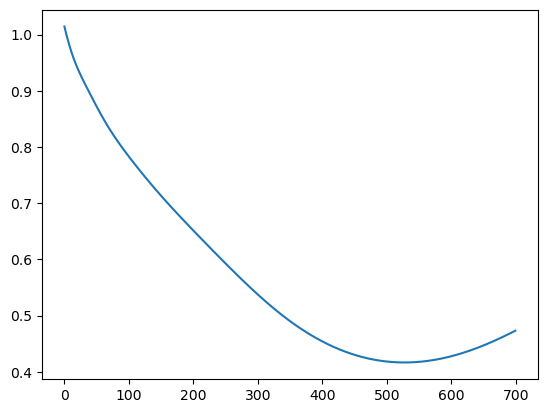

  0%|          | 0/700 [00:00<?, ?it/s]

Noise:0.5075622200965881,obs:73252640.0
Noise:0.520610511302948,obs:56396192.0
Noise:0.5402126908302307,obs:44797144.0
Noise:0.513951301574707,obs:36589312.0
Noise:0.49471357464790344,obs:30546854.0
Noise:0.5209697484970093,obs:25944938.0
Noise:0.5629120469093323,obs:22326724.0
Noise:0.5697693228721619,obs:19407050.0
Noise:0.5237116813659668,obs:17011038.0
Noise:0.529669463634491,obs:15012896.0
Noise:0.5312663316726685,obs:13325554.0
Noise:0.5370175838470459,obs:11888074.0
Noise:0.5409224629402161,obs:10653387.0
Noise:0.5841481685638428,obs:9583983.0
Noise:0.5666250586509705,obs:8655901.0
Noise:0.559124767780304,obs:7844680.5
Noise:0.5546014904975891,obs:7132026.5
Noise:0.5608171820640564,obs:6505815.5
Noise:0.5568014979362488,obs:5952198.0
Noise:0.5801938772201538,obs:5462659.5
Noise:0.5981475114822388,obs:5028098.5
Noise:0.5809283256530762,obs:4642113.0
Noise:0.5941901206970215,obs:4298598.5
Noise:0.5876928567886353,obs:3992566.75
Noise:0.6495126485824585,obs:3719321.75
Noise:0.59042

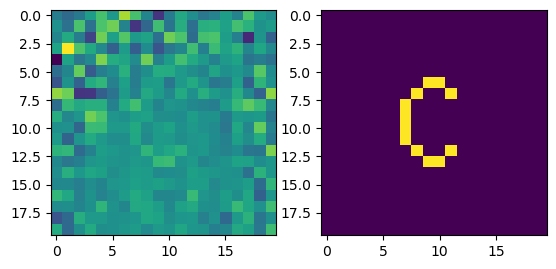

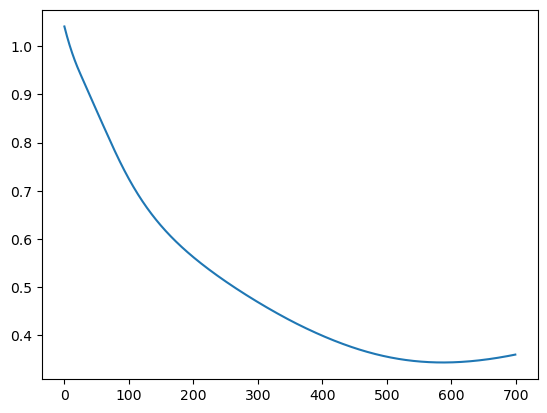

MSE: 0.360907856374979


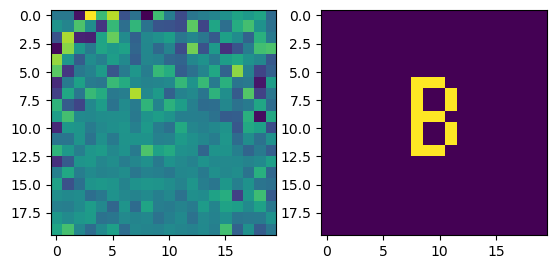

In [42]:
def MSE(pred,gt):
    mse=torch.mean(torch.square(pred-gt))
    return mse

sample_num = 4

cnt = 0
mse_sum = 0
for data in tqdm(drift_loader):
    y,gt = data
    y,gt = y[0].to(device).float(),  gt[0].to(device).float()
    gt = gt.reshape(1,1,20,20)
    sample_img = RedDiff(best_model,
                     A,    # 11520, 400
                            y,  # B, 11520
                            gt,     # B, 1, 20, 20
                            350,
                            ddim_eta=0.0001
                            )    # 400 FOR DEFAULT
    plt.figure()
    plt.subplot(121)
    plt.imshow(sample_img[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(gt[0][0].detach().cpu().numpy())
    mse_sum += MSE(sample_img,gt).detach().cpu().numpy()
    cnt += 1

    if sample_num ==cnt:
        break
print("MSE:",mse_sum/sample_num)

### PGDM

In [9]:
def pgdm_sample(
    diffusion,
    A,
    y,
    gt,
    batch_size,
    image_size = 20,
    channels = 1,
    ddim_timesteps=10,
    diffusion_steps = 100,
    ddim_eta=0.0,
    lam = 0.01,
    clip_denoised=True):
    
    # y = y.permute(1,0)
    # y = y[0]
    
    pinv_A = torch.linalg.pinv(A).to(device)
    c = diffusion_steps // ddim_timesteps
    ddim_timestep_seq = np.asarray(list(range(0, diffusion_steps, c)))
    ddim_timestep_seq = ddim_timestep_seq + 1
    ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])
    sample_img = torch.randn((batch_size, channels, image_size, image_size), device=device)

    Loss_history = []
    Loss_function = nn.MSELoss()
    
#     model_kwargs = {"low_res": pred.to(device)}
    for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
        t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
        prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

        sample_img = sample_img.clone().to(device).requires_grad_(True)
        
        # 1. get current and previous alpha_cumprod
        # alpha_cumprod_t =  torch.tensor(diffusion.alphas_cumprod[ddim_timestep_seq[i]]).to(device) 
        # alpha_cumprod_t_prev = torch.tensor(diffusion.alphas_cumprod_prev[ddim_timestep_prev_seq[i]]).to(device)
        alpha_cumprod_t = diffusion.alpha_bars[t]
        alpha_cumprod_t_prev = diffusion.alpha_bars[prev_t] if t > 0 else diffusion.alphas[0]
        
        # 2. predict noise using model
        pred_noise = diffusion.network(sample_img, t)

        # 3. get the predicted x_0
        pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
        
        if clip_denoised:
            pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)

        Loss_history.append(Loss_function(gt,pred_x0).item())
        
        # 4. compute variance: "sigma_t(η)" -> see formula (16)
        # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        sigmas_t = ddim_eta * torch.sqrt((1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))

        # 5. compute "direction pointing to x_t" of formula (12)
        pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise

        # 5.5 add matx
        # pgdm 
        x0_pred_reshape = pred_x0.reshape(1,-1).permute(1,0)     # 400 B
        # mat  = torch.matmul(torch.matmul((y - torch.matmul(A,x0_pred_reshape)).T, torch.matmul(A,A.T) + rho * torch.eye(A.shape[0]).to(device)), A)   # 32 400
        # x0_pred_reshape = x0_pred_reshape.permute(1,0)           # B  400
        # mat_x = (mat.detach() * x0_pred_reshape).sum()           
        mat = (torch.matmul(pinv_A, y) - torch.matmul(pinv_A,torch.matmul(A, x0_pred_reshape))).reshape(400, -1)
        x0_pred_reshape = x0_pred_reshape.permute(1,0)
        mat_x = (mat.detach() * x0_pred_reshape).sum()    

        grad_term = torch.autograd.grad(mat_x, sample_img)[0]
        # grad_term = grad_term / torch.max(grad_term)
        grad_term = grad_term.detach()
        
        coeff =  alpha_cumprod_t.sqrt() * lam
        # 6. compute x_{t-1} of formula (12)
        x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img) + grad_term * coeff

        # # 6. compute x_{t-1} of formula (12)
        # x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

        sample_img = x_prev

    # plt.plot(Loss_history)
    # plt.show()

    sample_img -= torch.min(sample_img)
    sample_img *= 1 / torch.max(sample_img)
    
    return sample_img

  0%|          | 0/18 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

MSE: 0.43473563250154257


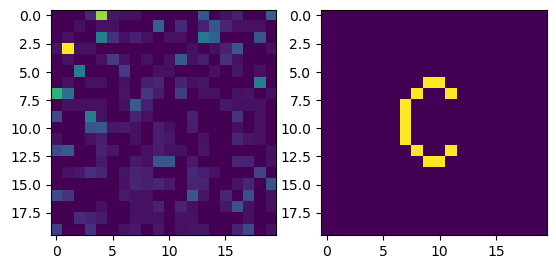

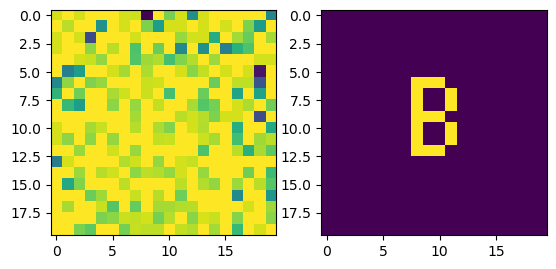

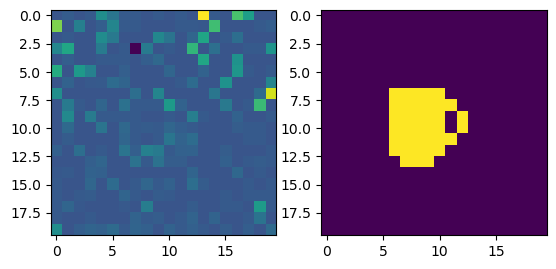

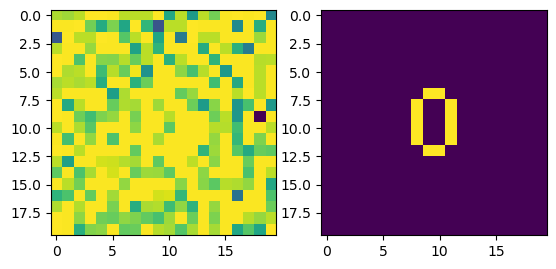

In [121]:

def MSE(pred,gt):
    mse=torch.mean(torch.square(pred-gt))
    return mse

sample_num = 4

cnt = 0
mse_sum = 0
for data in tqdm(drift_loader):
    y,gt = data
    y,gt = y[0].to(device).float(),  gt[0].to(device).float()
    gt = gt.reshape(1,1,20,20)
    sample_img = pgdm_sample(best_model, A,    # 11520, 400
                            y,  # B, 11520
                            gt,     # B, 1, 20, 20
                            1,
                            image_size=20,
                            channels = 1, 
                            ddim_timesteps= 200, 
                            diffusion_steps = 1000, 
                            ddim_eta=0.00, 
                            lam = 0.03, clip_denoised=True)
    plt.figure()
    plt.subplot(121)
    plt.imshow(sample_img[0,0].detach().cpu().numpy())
    plt.subplot(122)
    plt.imshow(gt[0][0].detach().cpu().numpy())
    mse_sum += MSE(sample_img,gt).detach().cpu().numpy()
    cnt += 1

    if sample_num ==cnt:
        break
print("MSE:",mse_sum/sample_num)
